In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
autoreload 2

In [4]:
import colorcolorfig
import simparam

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams

In [6]:
rcParams['text.usetex'] = True
rcParams['figure.figsize']=[6,4]
rcParams['figure.dpi']=300
rcParams['font.size']=12    # text big enough for a half-page fig
rcParams['axes.labelsize'] = 12      # fontsize of the x and y labels
rcParams['axes.titlesize'] = 12      # fontsize of the axes title
rcParams['xtick.labelsize'] = 12      # fontsize of the x and y labels
rcParams['ytick.labelsize'] = 12      # fontsize of the x and y labels
rcParams['lines.linewidth']=1.5
rcParams['lines.color']='k'     # thicker black lines 
rcParams['lines.markersize']=6
rcParams['lines.markeredgewidth']=1.     # big fat points
rcParams['axes.linewidth']=1.
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['xtick.major.width'] = 1.5      # major tick thickness in points
rcParams['xtick.minor.width'] = 1.2      # major tick thickness in points
rcParams['xtick.major.size'] = 6      # major tick size in points
rcParams['xtick.minor.size'] = 4      # minor tick size in points
rcParams['xtick.major.pad'] = 5      # distance to major tick label in points
rcParams['xtick.minor.pad'] = 5      # distance to the minor tick label in points
rcParams['ytick.major.width'] = 1.5      # major tick thickness in points
rcParams['ytick.minor.width'] = 1.2      # major tick thickness in points
rcParams['ytick.major.size'] = 6      # major tick size in points
rcParams['ytick.minor.size'] = 4      # minor tick size in points
rcParams['ytick.major.pad'] = 5      # distance to major tick label in points
rcParams['ytick.minor.pad'] = 5      # distance to the minor tick label in points
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

In [7]:
import pickle
import glob,os
import numpy as np
import astropy
from astropy.io import fits, ascii
from astropy.table import Table,vstack
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

import sncosmo

# No longer needed:
#from starDust2 import classify
#import sfdmap
#import pierel_util

# sncosmo simulations

Runs a random sampling simulation, generating a bunch of simulated SN observations in
color-magnitude space for each of the three main SN sub-types (Ia, Ib/c, II).

In [8]:
# normal ~ (mu,stdd), uniform ~ (lower,upper)
# x1_range defaults [0,1.] (normal)
# c_range defaults [0,0.1] (normal)
# t0_range defaults [0,0] ie at peak (salt) or explosion (some cc) (uniform)
# z_range defaults [1.8,2.2] originally written for Nebra (uniform)
# x0 (normal, LF and basic flcdm)

clobber = 0 # if >1 will overwrite a pickle, otherwise will load the pickle with snroot
nsim = 10000 # number of sample points for each SN class.
snroots = ['sim_SN2','sim_SN2_wide','sim_SN1','sim_SN3','sim_full_paramspace']
snroot_distinguish = str(int(nsim))
snroots = [i+'_'+snroot_distinguish for i in snroots]

# t0 is the observer-frame time corresponding to the source’s phase=0. 
# sample over (rf time constraints)*1+z

# make simulation over full parameter space for putting all three together
# same time range as SN2 wide, rf t0 ~ [-20,100]
sim_all3ims = colorcolorfig.sncosmo_sim(
    snroot='sim_full_paramspace', 
    z_range=[1.94,1.96], t0_range=[-60,300],
    filterset='kfo',nsim=nsim, verbose=clobber, clobber=clobber,
    mwdust=clobber, mwEBV=.018)


# SN Requiem Data
photometry from Gabe, model magnifications from Johan

In [9]:
"""
from Gabe
Forget MODEL A/B (not well constrained)
MODELD allows the main cluster dark matter halo to wander around the reference position taken at the BCG center
MODELE allows the same central position offset and relax constraints on the BCG (velocity dispersion, cut radius)
MODELF fixes the DM halo on the BCG but relax the constraints on the BCG.

MODELH is the final model, which includes information from the MUSE data (additional multiple) which is external / independent from the SN or the quiescent galaxy. Also adds galaxy-scale perturbers following Newman et al. These perturbers now allow to better reproduce the overall shape of the quiescent galaxy (not just the position of its central position and the SN) with 2 morphological components 

Naming the images SN.1 SN.2 SN.3 from north to South (or West to East)
"""
z = 1.95
print('SN rest frame...')
print(160/(1+z),105/(1+z))
print('V ~ 550 is close to f160, U~ 365 is nearest to f105')
print('f105 - f160 ~ U-V')

phot = ascii.read(open('mrg0138_phot.txt','rb'))
# if need normalized
#phot_normalized = sncosmo.data_standardize_and_normalize(phot,zp=25,zpsys='ab')  # phot_normalized.flux, .fluxerr, .time, .band

lensing_modelC = ascii.read(open('lensing_modelC.txt','rb'))
lensing_modelD = ascii.read(open('lensing_modelD.txt','rb'))
lensing_modelE = ascii.read(open('lensing_modelE.txt','rb'))
lensing_modelF = ascii.read(open('lensing_modelF.txt','rb'))
lensing_modelH = ascii.read(open('lensing_modelH.txt','rb'))

phot

SN rest frame...
54.23728813559322 35.59322033898305
V ~ 550 is close to f160, U~ 365 is nearest to f105
f105 - f160 ~ U-V


time,band,psf_flux,apcorr,flux,fluxerr,bkgflux,zp,zpsys,id,img,mu,muerr,dtA,dtB,dtC
float64,str5,float64,float64,float64,float64,float64,float64,str2,int64,float64,float64,float64,int64,int64,int64
57588.03,f105w,0.0877,1.192,0.1311,0.0165,0.1902,23.9,ab,0,1.1,6.3,1.2,0,0,0
57588.03,f105w,2.3471,1.192,2.6767,0.016,0.2033,23.9,ab,1,1.2,11.4,4.9,242,280,160
57588.03,f105w,0.1748,1.192,0.1922,0.0157,0.2776,23.9,ab,2,1.3,7.1,1.1,137,160,83
57587.97,f160w,0.6113,1.262,0.6702,0.0433,0.7207,23.9,ab,0,1.1,6.3,1.2,0,0,0
57587.97,f160w,3.5715,1.262,3.9274,0.0453,0.7528,23.9,ab,1,1.2,11.4,4.9,242,280,160
57587.97,f160w,1.1265,1.262,1.2476,0.0442,1.2159,23.9,ab,2,1.3,7.1,1.1,137,160,83


### a little data restructuring

In [10]:
def Sort(sub_li): 
    # reverse = None (Sorts in Ascending order) 
    # key is set to sort using second element of  
    # sublist lambda has been used 
    sub_li.sort(key = lambda x: x[0]) 
    return sub_li

def binned(t,mag,n=100):
    # give list of times and corresponding mags from simulations
    # [tbin,mags], tbin ~ (tmin,tmax,tvals), mag_vals ~ (mag_mean,mag_sigma,mag_vals) 
    # for i in binned: plt.fillbetween(tbin,magmean,upper,lower)
    
    zipped = list(zip(t,mag))
    sort_zipped = Sort(zipped)
    # list comprehension breaks list into lists of size n  
    final = [zipped[i * n:(i + 1) * n] for i in range((len(zipped) + n - 1) // n )]  
    
    binned_vals = []
    for i in final:
        t = [j[0] for j in i]
        mag = [j[1] for j in i]
        t_med,t_sigma = np.median(t),np.std(t)
        mag_med,mag_sigma = np.median(mag),np.std(mag)
        binned_vals.append([(t_med,t_sigma,t),(mag_med,mag_sigma,mag)])
    
    return binned_vals

def lens_extinction(
    source='salt2-extended',zs=1.95,zl=0.338,Av=1,dust=sncosmo.CCM89Dust(),t=0):
    # the source makes no difference, dust has same effect on every model
    # the model as it would look like for obs at the lens plane w no dust
    model=sncosmo.Model(source=source)
    model.set(z=zs-zl) 
    # the model as it would look for obs at lens w dust
    dust_model = sncosmo.Model(source=source,effects=[dust],effect_names=['mw'],effect_frames=['obs'])
    dust_model.set(z=zs-zl)
    r_v = 3.1 # AV/E(B-V) typical value for diffuse ISM
    ebv = Av/r_v
    dust_model.set(mwebv=ebv,mwr_v=r_v)
    """
    I want to know how the dust dimmed f160w & f105w in our frame ie zl~0.338 further
    f160w ~ 16000 & f105w ~ 10500 (Angstrom), they have widths about 1500 (Angstrom)
    lens observer at these wavelengths/(1+zl) should correspond to the wavelengths for us
    I can get flux density at each of these filters eff wavelength w & wo dust
    the filters aren't terribly wide and throughputs are flat, will approximate mags using just eff wavelength
    that should get me an approximate vec shift (E(105-160),A160) I want w Av ~ 1 in the lens plane
    """
    # the intrinsic flux densities for lens observer at the corresponding wavelengths to bands we see  
    f160 = model.flux(t,[16000/(1+zl)])
    f105 = model.flux(t,[10500/(1+zl)])
    # dusty flux densities
    dustyf160 = dust_model.flux(t,[16000/(1+zl)])
    dustyf105 = dust_model.flux(t,[10500/(1+zl)])
    
    # what do the extinctions look like, A ~ mobs - m
    A160 = -2.5*np.log10(dustyf160/f160)
    A105 = -2.5*np.log10(dustyf105/f105)
    # my color mag is (x,y) ~ (f105w-f160w,f160w)
    # I want to show vector (E(105-160),A160)
    # color excess 
    E = A105 - A160
    return (E[0],A160[0])

def extinction_vector(source='salt2-extended',z=1.95,Av=1,dust = sncosmo.CCM89Dust(),t=0):
    # the no host dust model
    model = sncosmo.Model(source=source)
    model.set(z=z)
    # the dust model 
    dust_model = sncosmo.Model(source=source,effects=[dust],effect_names=['host'],effect_frames=['rest'])
    dust_model.set(z=z)
    r_v = 3.1 # AV/E(B-V) typical value for diffuse ISM
    ebv = Av/r_v
    dust_model.set(hostebv=ebv,hostr_v=r_v)
    
    # t ~ 0 defaults to peak, not important when we determine the extinction,color excess
    # stay the same throughought the lightcurve evolution, just property of dust distributions
    
    # the intrinsic mags
    m160 = model.bandmag('f160w','ab',t)
    m105 = model.bandmag('f105w','ab',t)
    # the observed mags after extinction
    dusty160 = dust_model.bandmag('f160w','ab',t)
    dusty105 = dust_model.bandmag('f105w','ab',t)
    
    # my color mag is (x,y) ~ (f105w-f160w,f160w)
    # I want to show vector (E(105-160),A160)
    # the extinctions
    A160 = dusty160 - m160 # should be ~ 1 mag 
    A105 = dusty105 - m105
    # color excess 
    E = A105 - A160
    return (E,A160)    

def color(data, band1='f105w', band2='f160w'):
    # m105 - m160
    # more neg is bluer, more pos is redder
    # data ~ the ith SN table
    f105 = data[data['band']==band1]['flux']
    f160 = data[data['band']==band2]['flux']
    return -2.5*np.log10(f105/f160)[0]

def m(data, band='f105w',demagnify=True,lensmodel=None):
    # data use the ith SN table
    # m105 by default, change band to 'f160w' if rather see that
    # uses actual ab zp given, ie not rescaled so abzp ~ 25 
    band_data = data[data['band']==band]
    mag = -2.5*np.log10(band_data['flux']) + band_data['zp']
    if demagnify:
        if lensmodel == None: # use magnification from phot table
            mag += 2.5*np.log10(band_data['mu'])
        else: # use particular lensmodel provided
            mag += 2.5*np.log10(lensmodel['MU'])
    return mag[0]

def dmag(data, band, demagnify=True, lensmodel=None):
    # data ~ the ith SN table
    # limit to just the bandpass of interest
    band_data = data[data['band']==band]
    flux = band_data['flux']
    fluxerr = band_data['fluxerr']
    dm = abs(-2.5*np.log10(1+fluxerr/flux))
    if demagnify:
        # include the uncertainty on magnification m ~ -2.5*log10(mu*f) + zp
        # not sure if i'm propagating this properly
        if lensmodel == None: # didn't provide particular lens model uses in phot table
            mu = data['mu']
            muerr = data['muerr']
        else: # you gave the ith SN lens model
            tmp = lensmodel
            mu = tmp['MU']
            muerr = tmp['ERR_MU']
            
        #x = np.sqrt((muerr/mu)**2+(fluxerr/flux)**2)
        dm_f = 2.5*np.log10(1+fluxerr/flux)
        dm_mu = 2.5*np.log10(1+muerr/mu)
        dm = np.sqrt(dm_f**2 + dm_mu**2)
    #[i for i in dm]
    return float(dm)

def dcolor(data, band1='f105w', band2='f160w', demagnify=False): 
    # lens model doesn't play in to color uncertainty, don't include demag err
    dm1 = dmag(data, band1, demagnify=demagnify)
    dm2 = dmag(data, band2, demagnify=demagnify)
    dcolor = np.sqrt(dm1**2 + dm2**2)
    return dcolor



In [11]:
# 3 images of SN broken into their own tables, make a little easier to feed into functions
snphot = {
    'SN1':phot[phot['id']==0],
    'SN2':phot[phot['id']==1],
    'SN3':phot[phot['id']==2]
}

t = phot['time'][0] 
sncolor = {
    'SN1':color(snphot['SN1']), 
    'SN2':color(snphot['SN2']), 
    'SN3':color(snphot['SN3'])
}    

sncolorerr = {
    'SN1':dcolor(snphot['SN1']), 
    'SN2':dcolor(snphot['SN2']), 
    'SN3':dcolor(snphot['SN3'])
}

isn1 = lensing_modelC['MODELC']=='SN.1'
isn2 = lensing_modelC['MODELC']=='SN.2'
isn3 = lensing_modelC['MODELC']=='SN.3'

lensmodel_dict = {
    'SN1':{
        'C':lensing_modelC[isn1], 
        'D':lensing_modelD[isn1], 
        'E':lensing_modelE[isn1], 
        'F':lensing_modelF[isn1], 
        'H':lensing_modelH[isn1]
    },
    'SN2':{
        'C':lensing_modelC[isn2], 
        'D':lensing_modelD[isn2], 
        'E':lensing_modelE[isn2], 
        'F':lensing_modelF[isn2], 
        'H':lensing_modelH[isn2]
    },
    'SN3':{
        'C':lensing_modelC[isn3], 
        'D':lensing_modelD[isn3], 
        'E':lensing_modelE[isn3], 
        'F':lensing_modelF[isn3], 
        'H':lensing_modelH[isn3]
    }
}

In [12]:
# make a master dict with all the model-corrected photometry
# This dict is indexed as  'snid-modelid-filter'
# e.g.   'SN1-0-f105w'  is SN image 1, model 0 (no lens model), filter F105W
#  and   'SN2-H-f160w'  is SN image 2, model H, filter F160W

model_corrected_photometry = {}
for band in ['f105w', 'f160w']:
    for lensid in ['0', 'C','D','E','F','H']:
        if lensid=='0':
            demagnify=False
            lensmodel=None
        else:
            demagnify=True

        for snid in ['SN1','SN2','SN3']:
            if demagnify:
                lensmodel = lensmodel_dict[snid][lensid]
                
            mag = m(snphot[snid], band=band, demagnify=demagnify, lensmodel=lensmodel)
            magerr = dmag(snphot[snid], band, demagnify=demagnify, lensmodel=lensmodel)
            model_corrected_photometry['%s-%s-%s'%(snid,lensid,band)]=[mag,magerr]

/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/astropy/table/table.py:3064: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


In [13]:
for key in model_corrected_photometry:
    print('{:s} : {:.2f} +- {:.2f}'.format(
        key, model_corrected_photometry[key][0], model_corrected_photometry[key][1]))
    if key.startswith('SN3'):
        print('')

SN1-0-f105w : 26.11 +- 0.13
SN2-0-f105w : 22.83 +- 0.01
SN3-0-f105w : 25.69 +- 0.09

SN1-C-f105w : 28.11 +- 0.15
SN2-C-f105w : 25.28 +- 0.12
SN3-C-f105w : 27.78 +- 0.12

SN1-D-f105w : 28.10 +- 0.16
SN2-D-f105w : 25.32 +- 0.12
SN3-D-f105w : 27.87 +- 0.12

SN1-E-f105w : 28.48 +- 0.22
SN2-E-f105w : 26.00 +- 0.20
SN3-E-f105w : 28.50 +- 0.22

SN1-F-f105w : 28.45 +- 0.20
SN2-F-f105w : 25.97 +- 0.18
SN3-F-f105w : 28.45 +- 0.20

SN1-H-f105w : 27.59 +- 0.19
SN2-H-f105w : 25.00 +- 0.37
SN3-H-f105w : 27.44 +- 0.25

SN1-0-f160w : 24.33 +- 0.07
SN2-0-f160w : 22.41 +- 0.01
SN3-0-f160w : 23.66 +- 0.04

SN1-C-f160w : 26.34 +- 0.11
SN2-C-f160w : 24.86 +- 0.12
SN3-C-f160w : 25.75 +- 0.09

SN1-D-f160w : 26.33 +- 0.11
SN2-D-f160w : 24.91 +- 0.12
SN3-D-f160w : 25.84 +- 0.10

SN1-E-f160w : 26.71 +- 0.19
SN2-E-f160w : 25.58 +- 0.20
SN3-E-f160w : 26.47 +- 0.21

SN1-F-f160w : 26.68 +- 0.17
SN2-F-f160w : 25.56 +- 0.18
SN3-F-f160w : 26.42 +- 0.19

SN1-H-f160w : 25.81 +- 0.15
SN2-H-f160w : 24.59 +- 0.38
SN3-H-f16

## Base SN Ia color-mag curve 
This is the curve that a SNIa traces out in color-mag space over time. 
To show the time dimension we will use color-coding with time labels.

In [14]:
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source='salt2-extended',
                      effects=[dust, dust],
                      effect_names=['host', 'mw'],
                      effect_frames=['rest', 'obs'])

time = np.linspace(-20,100,1000)
def model_color(source='salt2-extended',
                return_obsframe_time=True, do_dust=True,
                cosmo = FlatLambdaCDM(H0=70, Om0=0.3),
                MR=-19.37, # Vega, Wang+2006 and Graur+2014; # alt normalization: MB=-19.25 (Richardson+ 2014)
                time=np.linspace(-20,100,1000),
                param_dict=None,printt=False,ebv=.014,c=None):
    # color curve m105w-m160w for a SN template 
    z=1.95
    if do_dust:
        dust = sncosmo.CCM89Dust()
        model = sncosmo.Model(source=source,
                effects=[dust, dust],
                effect_names=['host', 'mw'],
                effect_frames=['rest', 'obs'])
    
    # look up ra dec if want to set mw dust
    #dustmap = sfdmap.SFDMap('/Users/kyleoconnor/Documents/GitHub/sfdmap/sfddata-master/')
    #ebv = dustmap.ebv(ra, dec)
    # 
        model.set(z=1.95,mwebv=ebv) # optionally include mwebv=ebv & **param_dict
    else:
        model = sncosmo.Model(source=source)
        model.set(z=1.95)
    if c != None: # color param in salt2, default is None, to show unc region need to provide arg
        c = c
        model.set(c=c)
    
    if MR != None:
        model.set_source_peakabsmag( MR, 'bessellr', 'vega', cosmo=cosmo)
    #if MB != None:
    #    model.set_source_peakabsmag( MB, 'bessellb', 'vega', cosmo=cosmo)
       
    if printt:
        print(model.parameters,model.param_names)
    if return_obsframe_time:
        time *= (1+z)
    m160 = model.bandmag('f160w', 'ab', time)
    m105 = model.bandmag('f105w', 'ab', time)
    c = m105 - m160
    return [c,m105,m160,time]

/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in subtract


25.400743198867666


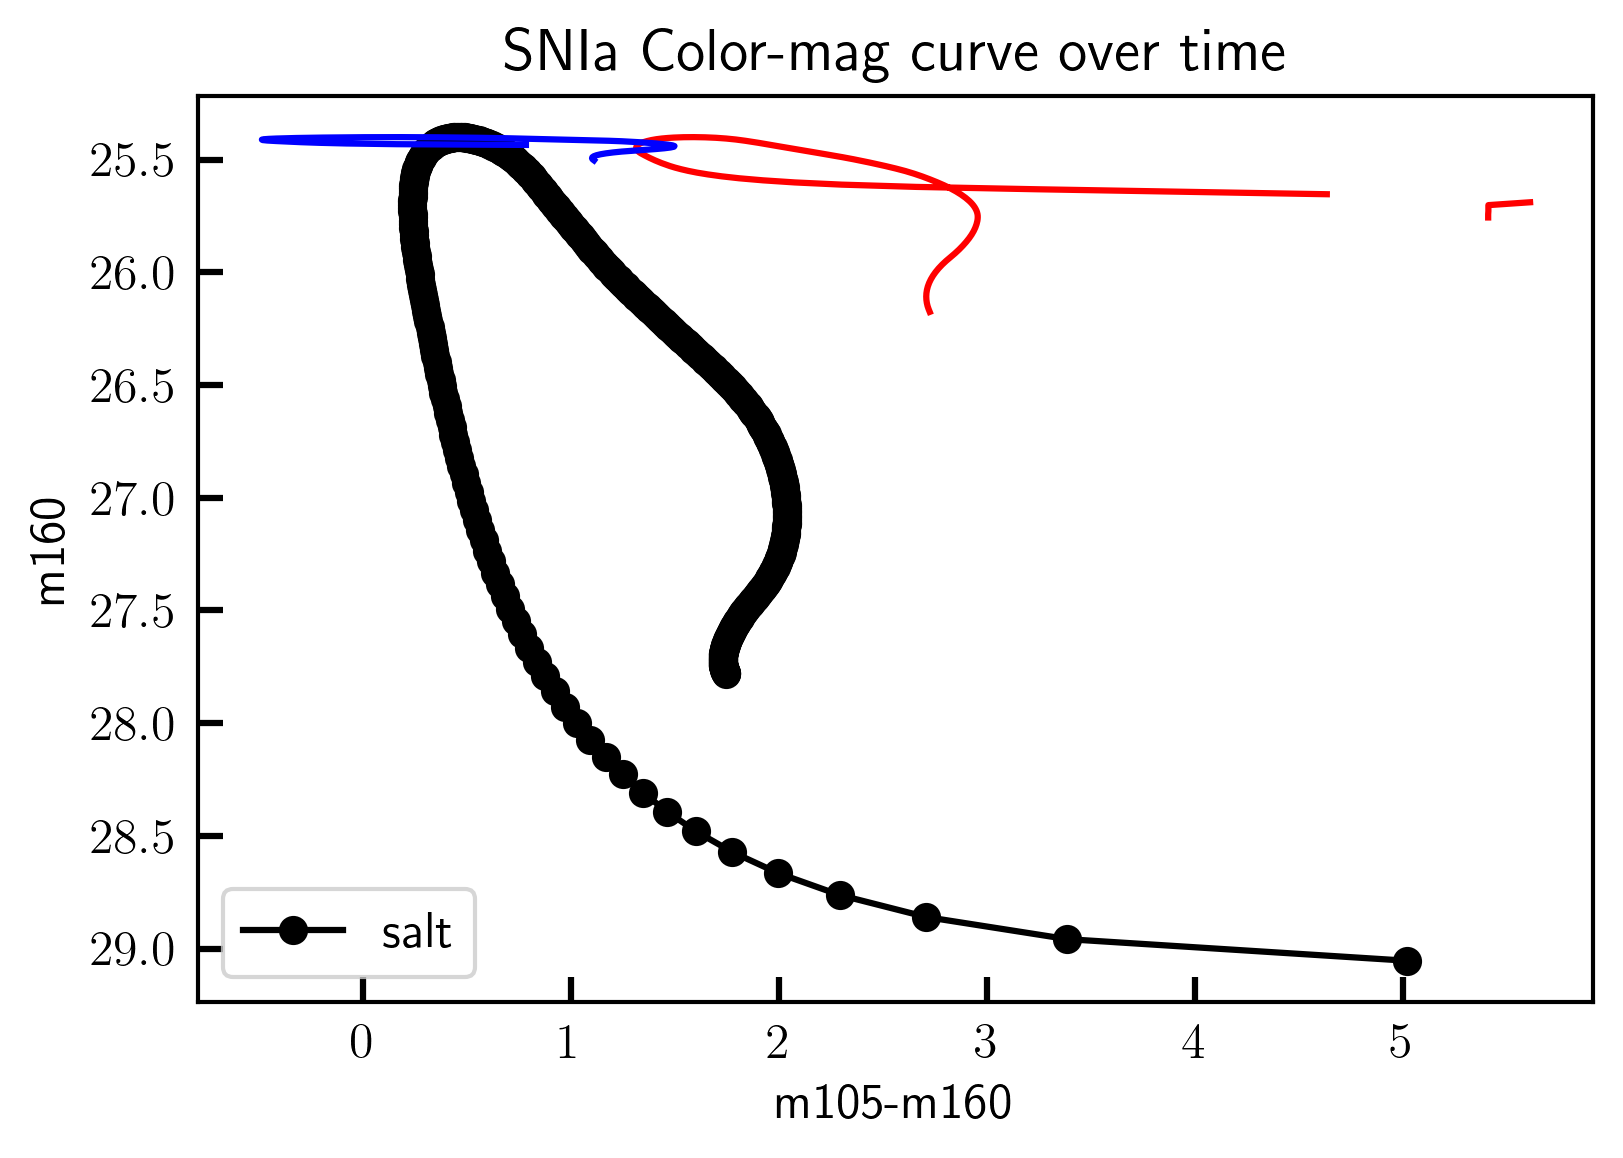

In [15]:
c,m105,m160,time = model_color(printt=False)

# if want uncertainty region from color param shaded use these to set c 
cup,clow = model_color(c=.5)[0],model_color(c=-.3)[0]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot( c, m160,label='salt',marker='o',color='black')

#for dm in np.arange(-0.5,0.5,0.01):
#    plt.fill_between(c, m160+dm, m160, color='0.8', alpha=1)
ax.plot( cup, m160, color='r')
ax.plot( clow, m160, color='b')


ax.set_xlabel('m105-m160')
ax.set_ylabel('m160')
ax.invert_yaxis()
ax.legend()
ax.set_title('SNIa Color-mag curve over time',fontsize='large')

print(np.min(m160))
#plt.savefig('Ia_Color.pdf',bbox_inches='tight')

### Now add the color-coding and time labels

In [16]:
import matplotlib.collections as mcoll
import matplotlib.path as mpath

def colorline(x, y, do_times=False, t=None, 
              t_step=20, z=None, 
              cmap=plt.get_cmap('copper'), 
              norm=plt.Normalize(0.0, 1.0),
              linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)
    
    if do_times:
        #tmp = list(zip([x,y,t])
        for tmp_t in np.arange(min(t),max(t),t_step):
            i = np.where(np.abs(t-tmp_t)==np.min(np.abs(t-tmp_t)))[0][0]
            x_loc,y_loc,t_val = x[i],y[i],t[i] # rf t_val at the color,mag value 
            # none xycoords should default to same axis
            ax.annotate('t ~ {}'.format(int(t_val)),(x_loc,y_loc),fontsize=10) 
            
    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

In [17]:
plt.fill_betweeny?

Object `plt.fill_betweeny` not found.


Text(0.5, 1.0, 'SNIa Color-mag curve over time')

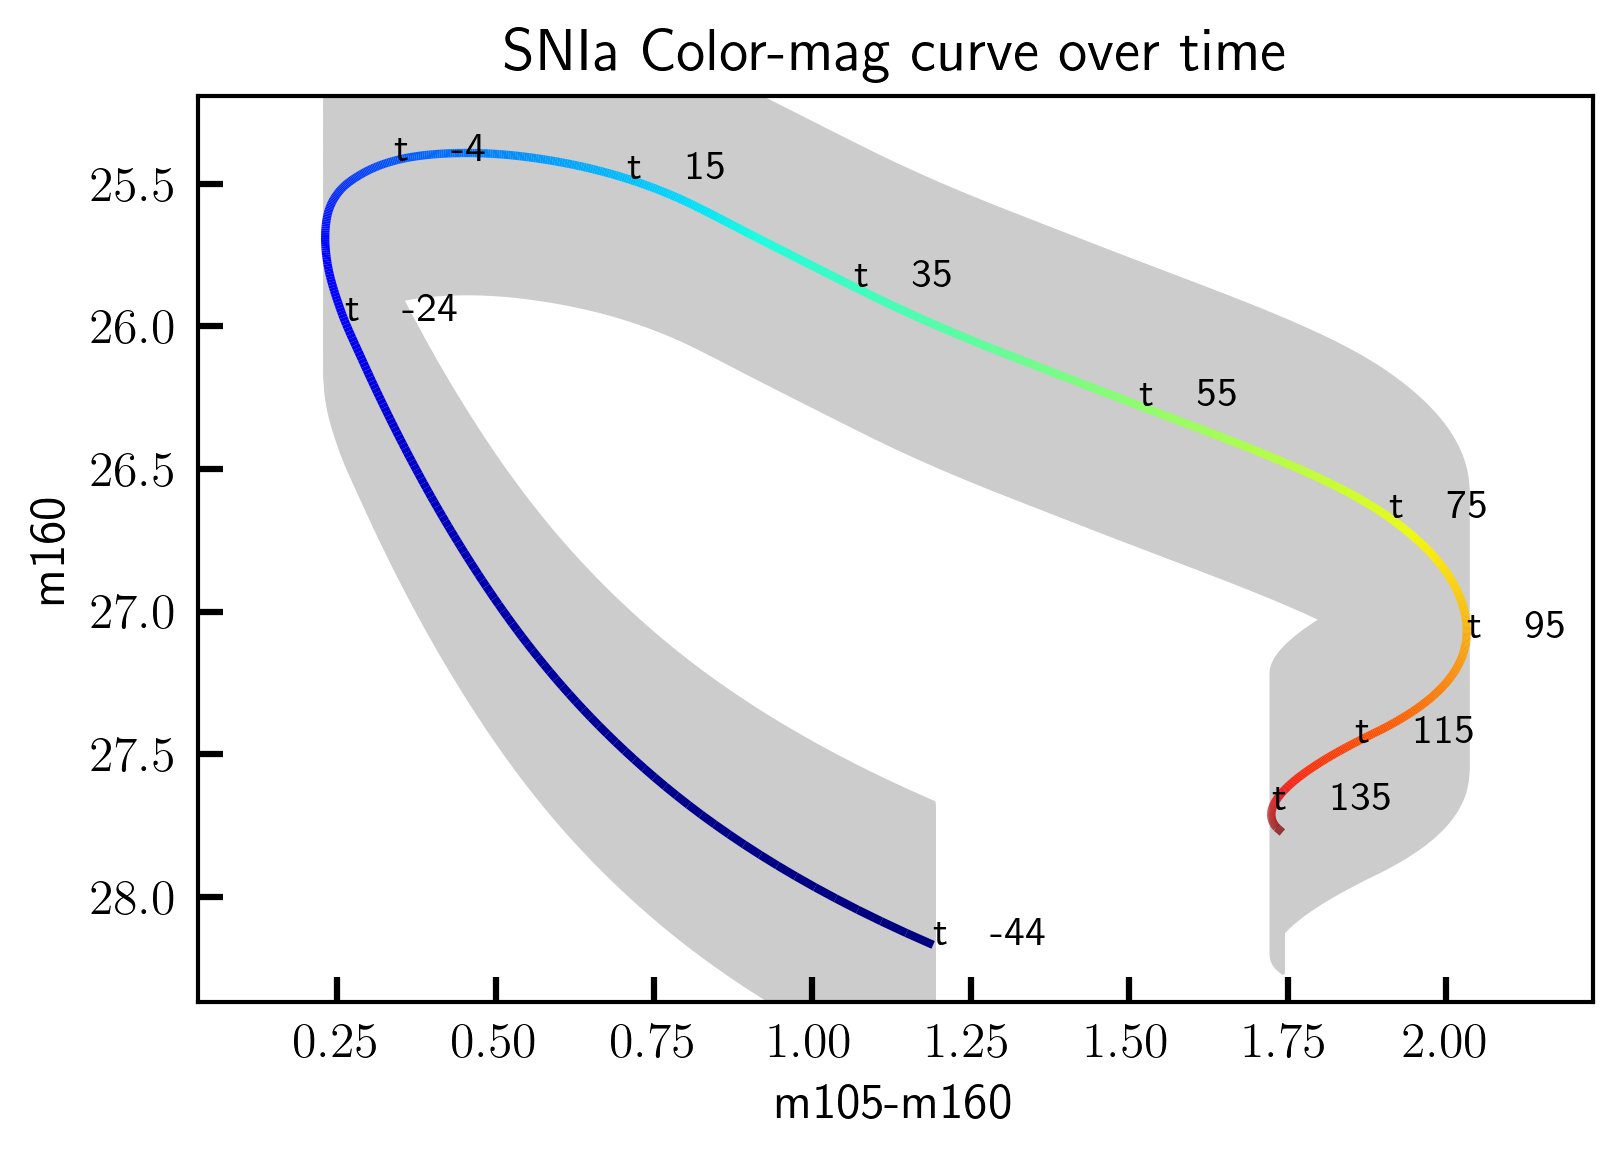

In [18]:
fig, ax = plt.subplots()
time = np.linspace(-15,50,1000)
c,m105,m160,t = model_color(do_dust=False,time=time)

for dm in np.arange(-0.5,0.5,0.01):
    plt.fill_between(c, m160+dm, m160, color='0.8', alpha=1)


#z = np.linspace(0, 1, len(c))
colorline(c, m160,do_times=True,t=t,t_step=20, cmap=plt.get_cmap('jet'), linewidth=2)

#cup,clow = model_color(c=.5,printt=False)[0],model_color(c=-.3,printt=False)[0]
#ax.fill_between(t,clow,cup,color='grey',alpha=.7)

#ax = plt.gca()
ax.set_xlim(min(c)-0.2,max(c)+0.2)
ax.set_ylim(min(m160)-0.2,max(m160)+0.2)
ax.invert_yaxis()
ax.set_xlabel('m105-m160')
ax.set_ylabel('m160')
ax.set_title('SNIa Color-mag curve over time',fontsize='large')

# Make the final figure:  color-mag contours and colored timeline
(left) contours enclose 68% and 95% of the population for each SN type
(right) colored line shows the evolution of a Type Ia SN in color-mag space over time

In [19]:
# Define the min and max from the full range of lens models considered
#m1_lens_range = model_corrected_photometry[]

# list of lens models to use for defining lens model uncertainty:
lensidlist = ['C','D','E','F','H'] 

for snid, marker in zip(['SN1', 'SN2', 'SN3'], ['s','o','^']):
    m0_105 = model_corrected_photometry['%s-0-f105w'%snid]
    m0_160 = model_corrected_photometry['%s-0-f160w'%snid]
        
    m_105 = np.array([model_corrected_photometry['%s-%s-f105w'%(snid,lensid)]
                      for lensid in lensidlist])
    m_160 = np.array([model_corrected_photometry['%s-%s-f160w'%(snid,lensid)] 
                      for lensid in lensidlist])
    print(m_105[:,1])

[0.15260072 0.15562215 0.221247   0.20239804 0.18950732]
[0.11627084 0.12431109 0.20196655 0.17735463 0.37495798]
[0.11701032 0.12234734 0.2191402  0.2011622  0.25062547]


/Users/rodney/Dropbox/src/snRequiem/Analysis/Classification/colorcolorfig.py:594: UserWarning: The following kwargs were not used by contour: 'ls'
  ax.contour( x[:-1], y[:-1], cabove, **plotargfinal )
/Users/rodney/Dropbox/src/snRequiem/Analysis/Classification/colorcolorfig.py:595: UserWarning: The following kwargs were not used by contour: 'ls'
  ax.contourf( x[:-1], y[:-1], cabove, **plotargfinal )
/Users/rodney/Dropbox/src/snRequiem/Analysis/Classification/colorcolorfig.py:598: UserWarning: The following kwargs were not used by contour: 'ls'
  ax.contourf( x[:-1], y[:-1], cabove, **plotargfinal )
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


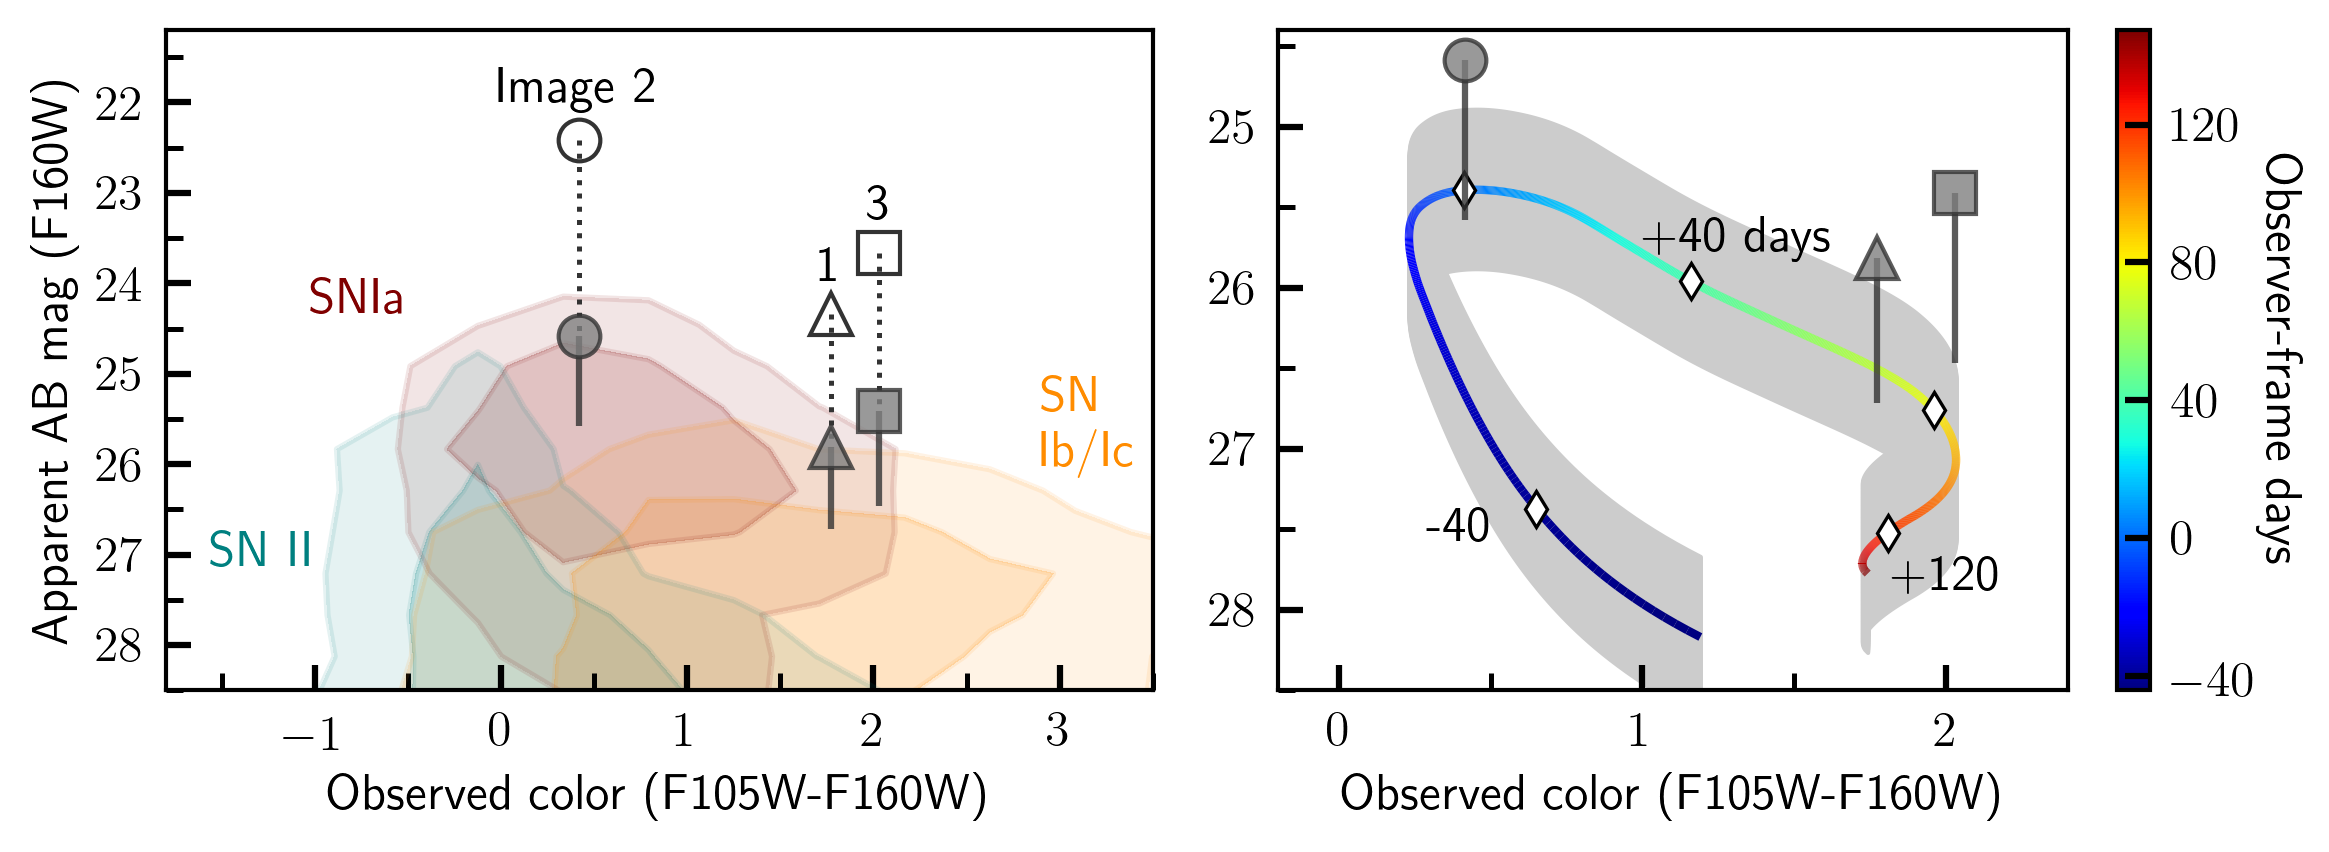

In [20]:
nbins = 12
contour_range = [[24,29.5],[-1.5,4.0]]
markertypes =  ['^','o','s']
markersize=10
label_times=True
showcontours = True
marker_alpha=0.8

# unpack the sncosmo simulations tuple (3 pickles)
sim1, sim2, sim3 = sim_all3ims

fig = plt.figure(figsize=[8,3])

# First subplot : the colored contours showing the simulated SN populations
ax1 = fig.add_subplot(1,2,1)
if showcontours:
    contours = colorcolorfig.plotcontours(
        sim1, sim2, sim3=sim3,
        band1='f105w',band2='f160w',band3='f160w',colorcolor=False,
        nbins=nbins,contour_range=contour_range, alpha=0.1)

# Second axes : the colored line showing time evolution for a SNIa
ax2 = fig.add_subplot(1,2,2)

# on ax2 plot the colored line and time-marker diamonds
time = np.linspace(-15,50,1000)
c,m105,m160,t = model_color(c=0, do_dust=False,time=time)
colorout = colorline(c, m160, z=t, norm=None,
                     do_times=False,t=t,t_step=40, cmap=plt.get_cmap('jet'), linewidth=2)

for dm in np.arange(-0.5,0.5,0.01):
    plt.fill_between(c, m160+dm, m160, color='0.8', alpha=1)

clrbar = plt.colorbar(colorout, ticks=[-40,0,40,80,120])
i_time_markers = np.where(t%40<0.2)[0]
ax2.plot(c[i_time_markers], m160[i_time_markers], 
        marker='d', color='w', mec='k', mew=0.8, ms=6, ls=' ', zorder=10)


# list of lens models to use for defining lens model uncertainty:
lensidlist = ['C','D','E','F','H'] 
bestlensmodel = 'H'

# Both axes: Plot the magnification-corrected 
#  color-magnitudes. On ax1 also show the original (uncorrected) color-mags
#  and a dotted line showing the mu correction
for ax in [ax1, ax2]:
    for snid, marker in zip(['SN1', 'SN2', 'SN3'], markertypes):
        # photometry as observed
        m0_105 = model_corrected_photometry['%s-0-f105w'%snid]
        m0_160 = model_corrected_photometry['%s-0-f160w'%snid]

        # color is not changed by lens model magnification corrections
        col = m0_105[0]-m0_160[0]
        colerr = np.sqrt(m0_105[1]**2 + m0_160[1]**2)
        
        # After applying best lens model for magnification correction
        m1_105 = model_corrected_photometry['%s-%s-f105w'%(snid,bestlensmodel)]
        m1_160 = model_corrected_photometry['%s-%s-f160w'%(snid,bestlensmodel)]

        # define the magnification uncertainty using the full range of
        # plausible lens model corrections
        m_105 = np.array([model_corrected_photometry['%s-%s-f105w'%(snid,lensid)]
                          for lensid in lensidlist])
        m_160 = np.array([model_corrected_photometry['%s-%s-f160w'%(snid,lensid)] 
                          for lensid in lensidlist])
        
        mag_uncert_105 = [[m1_105[0]-np.min(m_105[:,0])], [np.max(m_105[:,0])-m1_105[0]]]
        mag_uncert_160 = [[m1_160[0]-np.min(m_160[:,0])], [np.max(m_160[:,0])-m1_160[0]]]
        
        #[c1,c2,c3], [m1_lens_range,m2_lens_range,m3_lens_range], 
        #[obs_m1, obs_m2, obs_m3], [dm1_phot, dm2_phot, dm3_phot],
        # markertypes):
        if ax == ax1:
            ax.vlines(col, m0_160[0], m1_160[0], ls=':', lw=1.2, color='0.2')
            ax.plot(col, m0_160[0], #yerr=m0_160[1], xerr=colerr, 
                    alpha=marker_alpha, marker=marker,
                    color='black', markersize=markersize, fillstyle='none')
        ax.errorbar(col, m1_160[0], yerr=mag_uncert_160,
                    marker=marker, alpha=marker_alpha, mfc='0.5', 
                    color='0.2', markersize=markersize, zorder=20)
    ax.set_xlabel('Observed color (F105W-F160W)')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))


ax1.set_ylabel('Apparent AB mag (F160W)')   
ax1.set_xlim(-1.8, 3.5)
ax1.set_ylim(28.5, 21.2)

ax2.set_xlim(-0.2, 2.4)
ax2.set_ylim(28.5, 24.4)


# Optional: label the time-marker diamonds on the colorline
if label_times:
    ax2.text(0.5, 27.5, '-40', ha='right', va='center', color='k')
    #ax2.text(0.2, 25.5, 't=0', ha='right', va='center', color='k')
    ax2.text(1., 25.7, '+40 days', ha='left', va='center', color='k')
    #ax2.text(2.2, 26.8, '+80', ha='left', va='center', color='k')
    ax2.text(2.0, 27.8, '+120', ha='center', va='center', color='k')

# Label the contours:
ax1.text(-0.5,24.2, 'SNIa', color='maroon', ha='right', va='center')
ax1.text(-1,27, 'SN II', color='teal', ha='right', va='center')
ax1.text(2.9,25.6, 'SN\nIb/Ic', color='darkorange', ha='left', va='center')

# Label the observed photometry points
ax1.text(sncolor['SN1'], 
         model_corrected_photometry['SN1-0-f160w'][0]-0.25, 
         '1', ha='center', va='bottom')
ax1.text(sncolor['SN2'], 
         model_corrected_photometry['SN2-0-f160w'][0]-0.3, 
         'Image 2', ha='center', va='bottom')
ax1.text(sncolor['SN3'], 
         model_corrected_photometry['SN3-0-f160w'][0]-0.25, 
         '3', ha='center', va='bottom')

# Label the colorbar 
clrbar.set_label("Observer-frame days", rotation=-90, labelpad=10)


plt.tight_layout()
plt.savefig("../../Paper/Figures/snRequiem_classcontours_timeline.pdf", transparent=True)
plt.savefig("../../Paper/Figures/snRequiem_classcontours_timeline.png", transparent=True)



### NEW zoom-in classification figure

For the supplemental section, showing more details of the photometric classification, showing side-car histograms to show classification inference with no lens-model dependence (color alone); with lens-model magnification (color-mag). 

In [21]:
def get_mags(snsim, band1='f160w',band2='f105w',band3='f160w'):
    igood = np.where([np.all(snlc['flux']>0) for snlc in snsim.lightcurves])[0]
    # ibad = np.where([np.any(snlc['flux']<=0) for snlc in snsim.lightcurves])[0]
    lclist = [snsim.lightcurves[i] for i in igood]

    mag = np.array([
        -2.5*np.log10( np.ma.masked_less_equal(snlc['flux'],0,copy=False) )\
        + snlc['zp'] for snlc in lclist ])

    flt = np.array( [snlc['band'] for snlc in lclist] )
    i1 = np.where((flt == band1))
    i2 = np.where((flt == band2))
    i3 = np.where((flt == band3))
    m1 = mag[i1]
    m2 = mag[i2]
    m3 = mag[i3] 
    return(m1,m2,m3)

In [137]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

colormin = -0.5
colormax = 2.8
colorbinwidth = 0.1

magmax = 27.8
magmin = 21.8
magbinwidth = 0.1

# unpack the sncosmo simulations tuple (3 pickles)
sim1, sim2, sim3 = sim_all3ims #  Ia, Ib/c, II

# Each simulation has the same number of MC samples.  To show the expected relative rates 
# we will rescale the histograms below.  Here are the fractions of SNe expected in each sub-class,
# based on the host galaxy mass and SFR (following Li+Hjorth 2011), 
# and adopting the rel. rates from Li+2011 for the Ib/c and II split
priors_from_host_data = {'Ia':0.624, 'II':0.358*(57./(57+19)), 'Ibc':0.358*(19./(57+19))}

/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


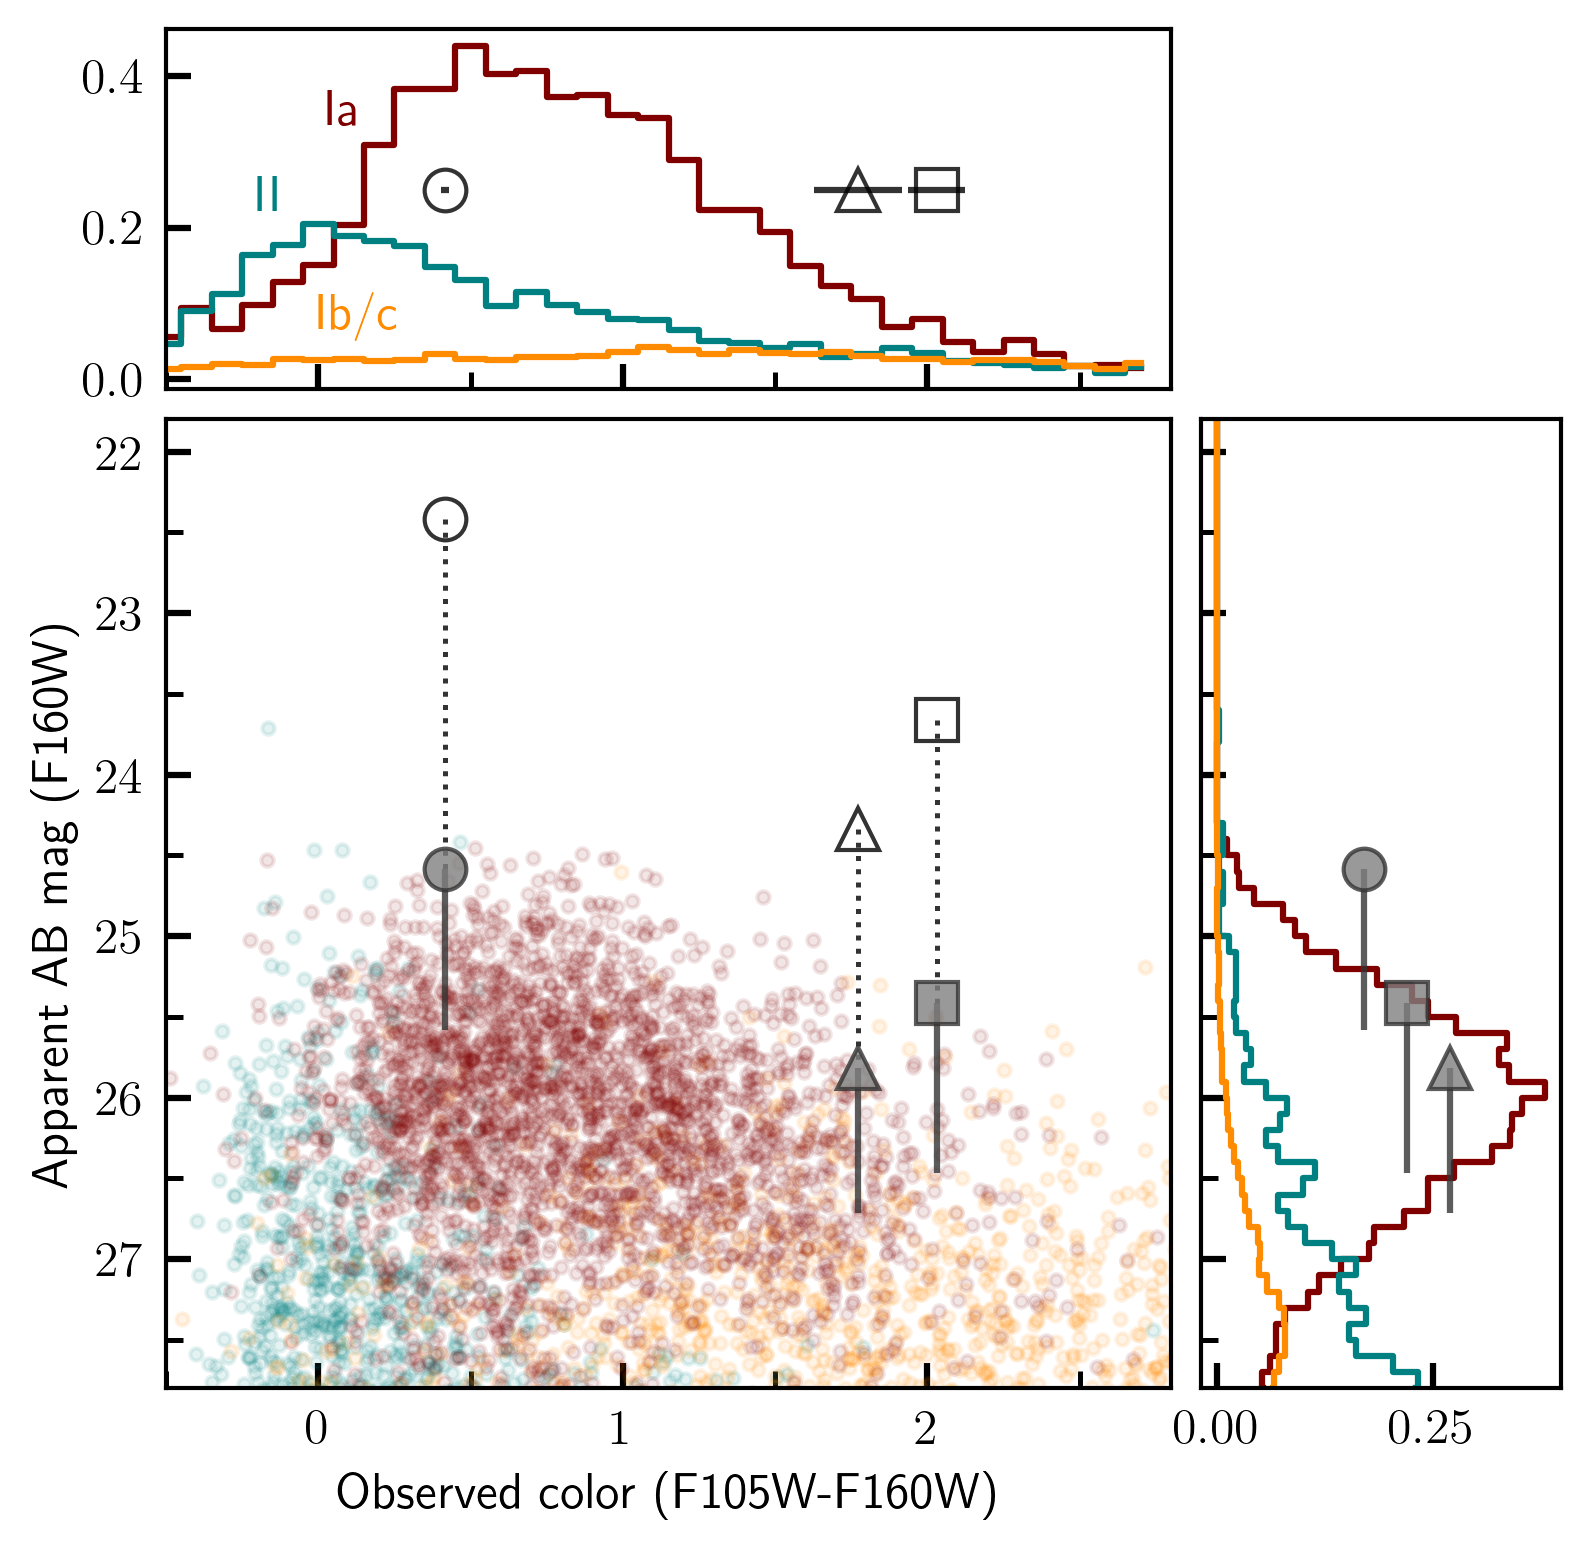

In [25]:

fig = plt.figure(figsize=[6,6])

ax = fig.add_subplot(111)
#ax.set_aspect(1.)

# the scatter plot on the main axes:
output = colorcolorfig.plotpoints(
        sim1, sim2, sim3=sim3,
        band1='f105w',band2='f160w',band3='f160w',colorcolor=False,
        alpha=0.1, ms=3)

ax.set_ylabel('Apparent AB mag (F160W)')   
ax.set_xlim(colormin, colormax)
ax.set_ylim(magmax, magmin)


ax.set_xlabel('Observed color (F105W-F160W)')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

# histograms
# create new axes on the right and on the top of the current axes.
divider = make_axes_locatable(ax)
axHistx = divider.append_axes("top", size=1.2, pad=0.1, sharex=ax)
axHisty = divider.append_axes("right", size=1.2, pad=0.1, sharey=ax)


xbins = np.arange(colormin, colormax + colorbinwidth, colorbinwidth)
ybins = np.arange(magmin, magmax + magbinwidth, magbinwidth)
for sim,color in zip(
    [sim1,sim2,sim3], [colorcolorfig._COLOR1, colorcolorfig._COLOR2, colorcolorfig._COLOR3]):
    histrescalefactor = priors_from_host_data[sim.sntype]
    m160, m105, m160 = get_mags(sim, 'f160w', 'f105w', 'f160w')
    #histout = axHistx.hist(m105-m160, bins=xbins, color=color, histtype='step') #alpha=0.3)
    #histout = axHisty.hist(m160, bins=ybins, orientation='horizontal', color=color, histtype='step') #alpha=0.3)
    histoutx = np.histogram(m105-m160, bins=xbins, density=True) 
    histouty = np.histogram(m160, bins=ybins, density=True)
    axHistx.plot(histoutx[1][:-1], histoutx[0]*histrescalefactor,  color=color, 
                 drawstyle='steps-mid', marker=' ', ls='-') #alpha=0.3)
    axHisty.plot(histouty[0]*histrescalefactor, histouty[1][:-1], color=color, 
                 drawstyle='steps-mid', marker=' ', ls='-') #alpha=0.3)    
    
plt.setp(axHisty.get_yticklabels(), visible=False)
plt.setp(axHistx.get_xticklabels(), visible=False)

# list of lens models to use for defining lens model uncertainty:
lensidlist = ['C','D','E','F','H'] 
bestlensmodel = 'H'

# Add in the observed SN Requiem data
for snid, marker, offset in zip(
    ['SN1', 'SN2', 'SN3'], markertypes, [0.27,0.17,0.22]):
    # photometry as observed
    m0_105 = model_corrected_photometry['%s-0-f105w'%snid]
    m0_160 = model_corrected_photometry['%s-0-f160w'%snid]

    # color is not changed by lens model magnification corrections
    col = m0_105[0]-m0_160[0]
    colerr = np.sqrt(m0_105[1]**2 + m0_160[1]**2)

    # After applying best lens model for magnification correction
    m1_105 = model_corrected_photometry['%s-%s-f105w'%(snid,bestlensmodel)]
    m1_160 = model_corrected_photometry['%s-%s-f160w'%(snid,bestlensmodel)]

    # define the magnification uncertainty using the full range of
    # plausible lens model corrections
    m_105 = np.array([model_corrected_photometry['%s-%s-f105w'%(snid,lensid)]
                      for lensid in lensidlist])
    m_160 = np.array([model_corrected_photometry['%s-%s-f160w'%(snid,lensid)] 
                      for lensid in lensidlist])

    mag_uncert_105 = [[m1_105[0]-np.min(m_105[:,0])], [np.max(m_105[:,0])-m1_105[0]]]
    mag_uncert_160 = [[m1_160[0]-np.min(m_160[:,0])], [np.max(m_160[:,0])-m1_160[0]]]
        
    ax.vlines(col, m0_160[0], m1_160[0], ls=':', lw=1.2, color='0.2')
    ax.plot(col, m0_160[0], #yerr=m0_160[1], xerr=colerr, 
            alpha=marker_alpha, marker=marker,
            color='black', markersize=markersize, fillstyle='none')
    ax.errorbar(col, m1_160[0], yerr=mag_uncert_160,
                marker=marker, alpha=marker_alpha, mfc='0.5', 
                color='0.2', markersize=markersize, zorder=20)

    axHisty.errorbar(offset, m1_160[0], yerr=mag_uncert_160,
                marker=marker, alpha=marker_alpha, mfc='0.5', 
                color='0.2', markersize=markersize, zorder=20)
    axHistx.errorbar(col, 0.25, xerr=colerr,
                     alpha=marker_alpha, marker=marker,
                     color='black', markersize=markersize, fillstyle='none')
    
    #axHistx.axvspan(col-colerr, col+colerr, color='k', alpha=0.2)
    #axHisty.axhspan(m_160[:,0].min(), m_160[:,0].max(), color='k', alpha=0.2)


axHistx.text(0.15, 0.38, 'Ia', ha='right', va='top', color=colorcolorfig._COLOR1)
axHistx.text(-0.2, 0.21, 'II', ha='left', va='bottom', color=colorcolorfig._COLOR2)
axHistx.text(0, 0.05, 'Ib/c', ha='left', va='bottom', color=colorcolorfig._COLOR3)
    
plt.savefig("../../Paper/Figures/colormag_classification_supplement.pdf", transparent=True)

In [163]:
priors_from_host_data

{'Ia': 0.624, 'II': 0.26849999999999996, 'Ibc': 0.0895}

In [157]:
def get_simulated_magnitudes(sim, band):
    iband = np.where(sim.lightcurves[0]['band']==band.lower())[0][0]
    zp = sim.lightcurves[0]['zp'][iband]
    f = np.array([lc['flux'][iband] for lc in sim.lightcurves])
    mdefault = np.ones(len(f)) * 40
    m = np.where(f>0, -2.5*np.log10(f)+zp, mdefault)
    return(m)

def get_colormag_classification_probability_by_image(
    nsigma_color=3, nsigma_mag=3, min_color_radius=0.1, min_mag_radius=0.1,
    priors = priors_from_host_data):
    """Compute a (crude) classification probability from the color-magnitude info alone
    (i.e. not including any model-predicted time delays).  
    
    Method: using the previously-defined sncosmo simulations, count the number of 
    simulated SN that fall within a box centered on the observed photometry points in color-mag space. 
    The size of the box in the color direction is the greater 
    of min_color_radius and (nsigma_color * the observed color uncertainty). 
    Likewise in the mag direction. 
        
    """
    posterior_by_image = {}
    # def colormag_classification_probability
    for snid in ['SN1', 'SN2', 'SN3']:
        # photometry as observed
        m0_105 = model_corrected_photometry['%s-0-f105w'%snid]
        m0_160 = model_corrected_photometry['%s-0-f160w'%snid]

        # color is not changed by lens model magnification corrections
        col = m0_105[0]-m0_160[0]
        colerr = np.sqrt(m0_105[1]**2 + m0_160[1]**2)

        # After applying best lens model for magnification correction
        m1_105 = model_corrected_photometry['%s-%s-f105w'%(snid,bestlensmodel)]
        m1_160 = model_corrected_photometry['%s-%s-f160w'%(snid,bestlensmodel)]

        # define the magnification uncertainty using the full range of
        # plausible lens model corrections
        m_105 = np.array([model_corrected_photometry['%s-%s-f105w'%(snid,lensid)]
                          for lensid in lensidlist])
        m_160 = np.array([model_corrected_photometry['%s-%s-f160w'%(snid,lensid)] 
                          for lensid in lensidlist])

        mag_uncert_105 = [[m1_105[0]-np.min(m_105[:,0])], [np.max(m_105[:,0])-m1_105[0]]]
        mag_uncert_160 = [[m1_160[0]-np.min(m_160[:,0])], [np.max(m_160[:,0])-m1_160[0]]]

        # Count up the number of simulated SN points within 1-sigma of each observation point.  
        nsim_nearby = {}
        for sim in [sim1,sim2,sim3]:
            m105_sim = get_simulated_magnitudes(sim, 'f105w')
            m160_sim = get_simulated_magnitudes(sim, 'f160w')
            col_sim = m105_sim - m160_sim
            inearby = np.where((np.abs(col-col_sim) < nsigma_color * max(min_color_radius,colerr)) &
                               (np.abs(m1_160[0]-m160_sim) < max(min_mag_radius, nsigma_mag*np.mean(mag_uncert_160)))
                              )[0]
            nsim_nearby[sim.sntype] = len(inearby)

        # Scale by the expected SN rates for each class to 
        # translate into a classification probability
        nsim_nearby_tot = np.sum([v for v in nsim_nearby.values()], dtype='float')
        posterior = {}
        for sim in [sim1,sim2,sim3]:
            sntype = sim.sntype
            posterior[sntype] = priors[sntype] * nsim_nearby[sntype]/nsim_nearby_tot
        evidence = np.sum([p for p in posterior.values()])
        for sim in [sim1,sim2,sim3]:
            sntype = sim.sntype
            posterior[sntype] /= evidence
        posterior_by_image[snid] = posterior
    return( posterior_by_image)

In [165]:
posterior_by_image = get_colormag_classification_probability_by_image(
    3, 3, 0.1, 0.1)
# priors={'Ia':0.33, 'II':0.33, 'Ibc':0.34})

/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


In [166]:
posterior_by_image

{'SN1': {'Ia': 0.9483703490049035, 'II': 0.0, 'Ibc': 0.05162965099509663},
 'SN2': {'Ia': 0.9778671383182898,
  'II': 0.020929988764226158,
  'Ibc': 0.0012028729174842622},
 'SN3': {'Ia': 0.9173001806039732, 'II': 0.0, 'Ibc': 0.08269981939602672}}

In [160]:
priors_from_host_data

{'Ia': 0.624, 'II': 0.26849999999999996, 'Ibc': 0.0895}

In [162]:
0.72*0.624/(0.72*0.624+0+0.28*0.0895)

0.9471686975587131

In [114]:
band = 'f105w'
#def get_simulated_magnitudes(sim, band):
iband = np.where(sim.lightcurves[0]['band']==band.lower())[0][0]
zp = sim.lightcurves[0]['zp'][iband]
f = np.array([lc['flux'][iband] for lc in sim.lightcurves])
mdefault = np.ones(len(f)) * 40
m = np.where(f>0, -2.5*np.log10(f)+zp, mdefault)

/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


In [118]:
m

array([40.        , 31.37918445, 32.04878385, ..., 28.49844956,
       30.0883792 , 40.        ])

In [112]:
f

array([[-0.01649804],
       [ 0.00904329],
       [ 0.00488075],
       ...,
       [ 0.12841631],
       [ 0.02969261],
       [-0.00467688]])

In [108]:
zp

26.27

In [ ]:

f = np.array([lc['flux'][iband] for lc in sim.lightcurves])
mdefault = np.ones(len(f)) * 40
m = np.where(f>0, -2.5*np.log10(f)+zp, mdefault)


In [76]:
m160 = return_simulated_maglist(sim1, 'f160w')

/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


In [77]:
m160


array([[40.        , 40.        , 40.        , ..., 40.        ,
        40.        , 40.        ],
       [26.47840237, 26.47840237, 26.47840237, ..., 26.47840237,
        26.47840237, 26.47840237],
       [30.83276892, 30.83276892, 30.83276892, ..., 30.83276892,
        30.83276892, 30.83276892],
       ...,
       [40.        , 40.        , 40.        , ..., 40.        ,
        40.        , 40.        ],
       [26.20931059, 26.20931059, 26.20931059, ..., 26.20931059,
        26.20931059, 26.20931059],
       [25.56698237, 25.56698237, 25.56698237, ..., 25.56698237,
        25.56698237, 25.56698237]])

In [64]:
nearcolor = (np.abs(col-col_sim) < 2*min(0.05,colerr))
nearmag = np.abs(m1_160[0]-m160_sim) < min(0.05, np.mean(mag_uncert_160))

In [65]:
nearcolor.sum()

1

In [66]:
nearmag.sum()

0

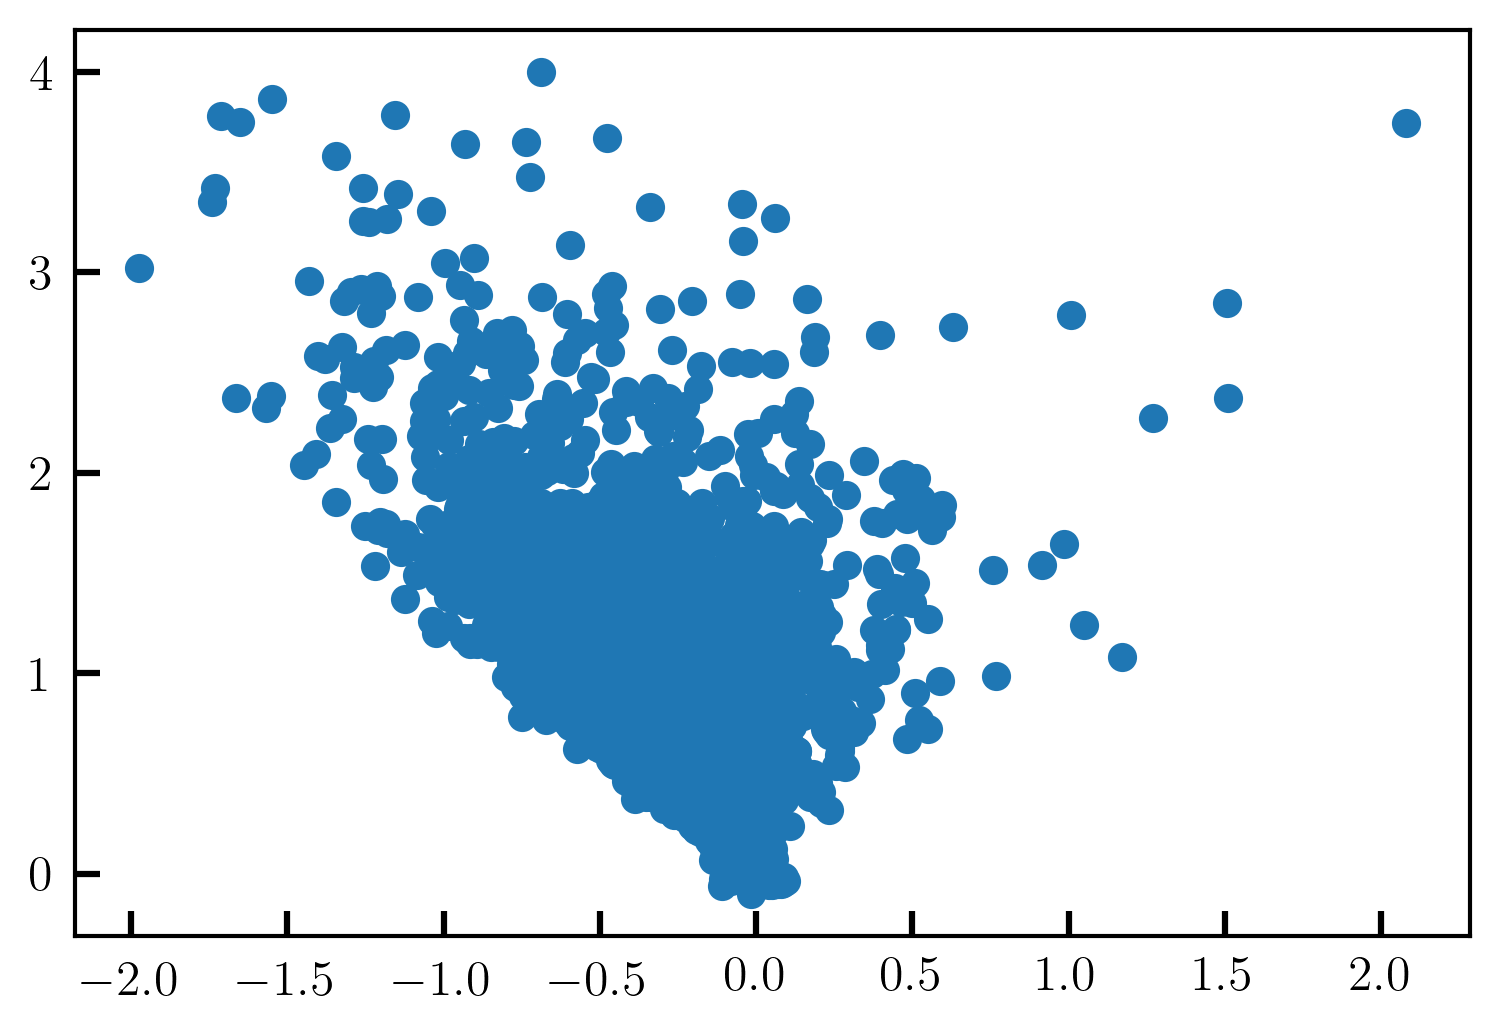

In [61]:
plt.scatter(col_sim, m160_sim)

# Stop here.  

There's some useful code below for adding in a dust vector, but at the moment we're not including that.

In [ ]:
host_dust_vector = extinction_vector()
lens_dust_vector = lens_extinction()
width=1.5
head_width=10
host_dust = False
dust_vector_location = [-.5,23.3]
xerr = (dc1,dc2,dc3)
alpha = 1
model_colors = {'A/B':'grey','C':'red','D':'blue','E':'yellow','F':'green'}
nbins = 10
small_xshift = .1
ylim = (22,28)
xlim = (-1,3)
t0_range = (-20,100) 
fmt = {'1':'^','2':'o','3':'s'}
markersize=15
contour_range = [[24,29.5],[-1.5,3.5]]

sim1,sim2,sim3=sim_all3ims[0],sim_all3ims[1],sim_all3ims[2]

figname = 'color_mag_contours_all.pdf'
figname_distinguish = str(int(sim1.nsim)) # nsims 
figname = figname[:-4] + '_'+figname_distinguish + figname[-4:]

lens_range,do_colorline=True,True
if lens_range: # remove various offset ind lens models
    figname = figname[:-4] + '_' + 'lensrange'
    # initialize figure put the three images using initial lensing models (A/B?) 
    ax = plt.gca() 
    plt.errorbar(c2, m2_lens_range[0], 
                 yerr=0, fmt=fmt['2'], alpha=alpha, 
                 color='0.5', markersize=markersize)
    ax.set_xlabel('m105-m160')
    ax.set_ylabel('m160')
    ax.vlines(c2,m2_lens_range[2],m2_lens_range[1],color='grey',lw=7.5)
    
    if do_colorline:
        time = np.linspace(-15,50,1000)
        c,m105,m160,t = model_color(do_dust=False,time=time)
        colorline(c, m160,do_times=True,t=t,t_step=20, cmap=plt.get_cmap('jet'), linewidth=2) 
    
    # arrow, draws from x,y to x+dx,y+dy
    if host_dust:
        ax.arrow(dust_vector_location[0], dust_vector_location[1], host_dust_vector[0], host_dust_vector[1],
                width=width,head_width=head_width,color='red',label='host dust')
        ax.annotate('Av = 1 mag of dust \n in the source (red) \n and lens plane (yellow)',dust_vector_location,fontsize=20,color='black')

        ax.arrow(dust_vector_location[0], dust_vector_location[1], lens_dust_vector[0], lens_dust_vector[1],
                width=width,head_width=head_width,color='yellow',label='lens plane dust')
    else:
        ax.annotate('Av = 1 mag of dust \n in the lens plane',dust_vector_location,fontsize=20,color='black')
        ax.arrow(dust_vector_location[0], dust_vector_location[1], lens_dust_vector[0], lens_dust_vector[1],
                width=width,head_width=head_width,color='red',label='lens plane dust')
        
    ax.errorbar(c1,m1_lens_range[0],yerr=0,fmt=fmt['1'],alpha=alpha,label='',color='grey',markersize=markersize)
    ax.vlines(c1,m1_lens_range[2],m1_lens_range[1],color='grey',lw=7.5)
    ax.errorbar(c3,m3_lens_range[0],yerr=0,fmt=fmt['3'],alpha=alpha,color='grey',markersize=markersize)
    ax.vlines(c3,m3_lens_range[2],m3_lens_range[1],color='grey',lw=7.5)

    contours = colorcolorfig.plotcontours(sim1,sim2,sim3=sim3,
                            band1='f105w',band2='f160w',band3='f160w',colorcolor=False,
                            nbins=nbins,contour_range=contour_range)

    ax.annotate('SN 1,2,3',(.01,.95),xycoords='axes fraction',fontsize=20)
    ax.annotate('t0 rf days {}'.format(t0_range),(.01,.90),xycoords='axes fraction',fontsize=20)

    ax.fill_between([0],[0],[0],label='Ia',alpha=0.3,color='maroon')
    ax.fill_between([0],[0],[0],label='II',alpha=0.3,color='teal')
    ax.fill_between([0],[0],[0],label='Ibc',alpha=0.3,color='darkorange')

    # SN3 the actual observed apparent mag (and small phot uncertainties for color,mag)
    # mag uncertainties became large with lens models (color unc stay small)
    ax.errorbar(c3,obs_m3,yerr=dm3_phot[1],xerr=xerr[2],label='obs3',fmt=fmt['3'],alpha=alpha,color='black',markersize=markersize,fillstyle='none')
    # SN2 the actual observed apparent mag (and small phot uncertainties)
    ax.errorbar(c2,obs_m2,yerr=dm2_phot[1],xerr=xerr[1],label='obs2',fmt=fmt['2'],alpha=alpha,color='black',markersize=markersize,fillstyle='none')
    # SN1 the actual observed apparent mag (and small phot uncertainties)
    ax.errorbar(c1,obs_m1,yerr=dm1_phot[1],xerr=xerr[0],label='obs1',fmt=fmt['1'],alpha=alpha,color='black',markersize=markersize,fillstyle='none')

    # limit range shown 
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xlim(xlim[0],xlim[1])

    # ticks idk why length isnt working to reduce number of ticks show
    ax.tick_params(axis='both',length=4,labelsize=20)
    # Scalar formatter
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

    plt.gca().invert_yaxis()
    plt.legend()
    #plt.title('Color Mag',fontsize=40)
    plt.savefig(figname,bbox_inches='tight')
else:
    # initialize figure put the three images using initial lensing models (A/B?) 
    ax = pierel_util.plot('errorbar',c2,m2,yerr=dm2[1],fmt=fmt['2'],alpha=alpha,fontsize=30,x_lab='m105-m160',y_lab='m160',color=model_colors['A/B'],markersize=markersize)

    if do_colorline:
        time = np.linspace(-15,50,1000)
        c,m105,m160,t = model_color(do_dust=False,time=time)
        colorline(c, m160,do_times=True,t=t,t_step=20, cmap=plt.get_cmap('jet'), linewidth=2)  
    # arrow, draws from x,y to x+dx,y+dy
    if host_dust:
        ax.arrow(dust_vector_location[0], dust_vector_location[1], host_dust_vector[0], host_dust_vector[1],
                width=width,head_width=head_width,color='red',label='host dust')
        ax.annotate('Av = 1 mag of dust \n in the source (red) \n and lens plane (yellow)',dust_vector_location,fontsize=20,color='black')

        ax.arrow(dust_vector_location[0], dust_vector_location[1], lens_dust_vector[0], lens_dust_vector[1],
                width=width,head_width=head_width,color='yellow',label='lens plane dust')
    else:
        ax.annotate('Av = 1 mag of dust \n in the lens plane',dust_vector_location,fontsize=20,color='black')
        ax.arrow(dust_vector_location[0], dust_vector_location[1], lens_dust_vector[0], lens_dust_vector[1],
                width=width,head_width=head_width,color='red',label='lens plane dust')
        
    ax.errorbar(c1,m1,yerr=dm1[1],fmt=fmt['1'],alpha=alpha,label='model A/B',color=model_colors['A/B'],markersize=markersize)
    ax.errorbar(c3,m3,yerr=dm3[1],fmt=fmt['3'],alpha=alpha,color=model_colors['A/B'],markersize=markersize)

    contours = colorcolorfig.plotcontours(sim1,sim2,sim3=sim3,
                            band1='f105w',band2='f160w',band3='f160w',colorcolor=False,
                            nbins=nbins,contour_range=contour_range)

    ax.annotate('SN 1,2,3',(.01,.95),xycoords='axes fraction',fontsize=20)
    ax.annotate('t0 rf days {}'.format(t0_range),(.01,.90),xycoords='axes fraction',fontsize=20)

    ax.fill_between([0],[0],[0],label='Ia',alpha=0.3,color='maroon')
    ax.fill_between([0],[0],[0],label='II',alpha=0.3,color='teal')
    ax.fill_between([0],[0],[0],label='Ibc',alpha=0.3,color='darkorange')

    # SN2 various lens models
    ax.errorbar(c2-small_xshift,m2_C,yerr=dm2_C[1],color=model_colors['C'],fmt=fmt['2'],alpha=alpha,markersize=markersize)
    ax.errorbar(c2-2*small_xshift,m2_D,yerr=dm2_D[1],color=model_colors['D'],fmt=fmt['2'],alpha=alpha,markersize=markersize)
    ax.errorbar(c2+small_xshift,m2_E,yerr=dm2_E[1],color=model_colors['E'],fmt=fmt['2'],alpha=alpha,markersize=markersize)
    ax.errorbar(c2+2*small_xshift,m2_F,yerr=dm2_F[1],color=model_colors['F'],fmt=fmt['2'],alpha=alpha,markersize=markersize)

    # SN1 various lens models
    ax.errorbar(c1-small_xshift,m1_C,yerr=dm1_C[1],label='model C',color=model_colors['C'],fmt=fmt['1'],alpha=alpha,markersize=markersize)
    ax.errorbar(c1-2*small_xshift,m1_D,yerr=dm1_D[1],label='model D',color=model_colors['D'],fmt=fmt['1'],alpha=alpha,markersize=markersize)
    ax.errorbar(c1+small_xshift,m1_E,yerr=dm1_E[1],label='model E',color=model_colors['E'],fmt=fmt['1'],alpha=alpha,markersize=markersize)
    ax.errorbar(c1+2*small_xshift,m1_F,yerr=dm1_F[1],label='model F',color=model_colors['F'],fmt=fmt['1'],alpha=alpha,markersize=markersize)

    # SN3 various lens models 
    ax.errorbar(c3-small_xshift,m3_C,yerr=dm3_C[1],color=model_colors['C'],fmt=fmt['3'],alpha=alpha,markersize=markersize)
    ax.errorbar(c3-2*small_xshift,m3_D,yerr=dm3_D[1],color=model_colors['D'],fmt=fmt['3'],alpha=alpha,markersize=markersize)
    ax.errorbar(c3+small_xshift,m3_E,yerr=dm3_E[1],color=model_colors['E'],fmt=fmt['3'],alpha=alpha,markersize=markersize)
    ax.errorbar(c3+2*small_xshift,m3_F,yerr=dm3_F[1],color=model_colors['F'],fmt=fmt['3'],alpha=alpha,markersize=markersize)

    # SN3 the actual observed apparent mag (and small phot uncertainties for color,mag)
    # mag uncertainties became large with lens models (color unc stay small)
    ax.errorbar(c3,obs_m3,yerr=dm3_phot[1],xerr=xerr[2],label='obs3',fmt=fmt['3'],alpha=alpha,color='black',markersize=markersize,fillstyle='none')
    # SN2 the actual observed apparent mag (and small phot uncertainties)
    ax.errorbar(c2,obs_m2,yerr=dm2_phot[1],xerr=xerr[1],label='obs2',fmt=fmt['2'],alpha=alpha,color='black',markersize=markersize,fillstyle='none')
    # SN1 the actual observed apparent mag (and small phot uncertainties)
    ax.errorbar(c1,obs_m1,yerr=dm1_phot[1],xerr=xerr[0],label='obs1',fmt=fmt['1'],alpha=alpha,color='black',markersize=markersize,fillstyle='none')

    # limit range shown 
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xlim(xlim[0],xlim[1])

    # ticks idk why length isnt working to reduce number of ticks show
    ax.tick_params(axis='both',length=4,labelsize=20)
    # Scalar formatter
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

    plt.gca().invert_yaxis()
    plt.legend()
    #plt.title('Color Mag',fontsize=40)
    plt.savefig(figname,bbox_inches='tight')

In [ ]:
host_dust_vector = extinction_vector()
dust_vector_location = [0,25.5]
xerr = dc1
alpha = 1
nbins = 10
small_xshift = .1
ylim = (24,29)
xlim = (-1,3)
t0_range = (15,30) 

contour_range = [[24,29.5],[-1.5,3.5]]

sim1,sim2,sim3=sim_SN1[0],sim_SN1[1],sim_SN1[2]

figname = 'color_mag_contours_image1.pdf'
figname_distinguish = str(int(sim1.nsim)) # nsims 
figname = figname[:-4] + '_'+figname_distinguish + figname[-4:]

ax = pierel_util.plot('errorbar',c1,m1,yerr=dm1[1],fmt=fmt['1'],label='modelA/B',alpha=alpha,fontsize=30,x_lab='m105-m160',y_lab='m160',color='blue')

# arrow, draws from x,y to x+dx,y+dy
ax.arrow(dust_vector_location[0], dust_vector_location[1], host_dust_vector[0], host_dust_vector[1],
        width=width,head_width=head_width,color='red',label='host dust')
ax.annotate('Av = 1 mag of dust \n in the source (red) \n and lens plane (yellow)',dust_vector_location,fontsize=20,color='black')

ax.arrow(dust_vector_location[0], dust_vector_location[1], lens_dust_vector[0], lens_dust_vector[1],
        width=width,head_width=head_width,color='yellow',label='lens plane dust')

contours = colorcolorfig.plotcontours(sim1,sim2,sim3=sim3,
                        band1='f105w',band2='f160w',band3='f160w',colorcolor=False,
                        nbins=nbins,contour_range=contour_range)

ax.annotate('SN1',(.1,.9),xycoords='axes fraction',fontsize=20)
ax.annotate('t0 rf days {}'.format(t0_range),(.05,.85),xycoords='axes fraction',fontsize=20)

ax.fill_between([0],[0],[0],label='Ia',alpha=0.3,color='maroon')
ax.fill_between([0],[0],[0],label='II',alpha=0.3,color='teal')
ax.fill_between([0],[0],[0],label='Ibc',alpha=0.3,color='darkorange')

small_xshift = .1
# various lens models
ax.errorbar(c1-small_xshift,m1_C,yerr=dm1_C[1],label='model C',fmt=fmt['1'],alpha=alpha)
ax.errorbar(c1-2*small_xshift,m1_D,yerr=dm1_D[1],label='model D',fmt=fmt['1'],alpha=alpha)
ax.errorbar(c1+small_xshift,m1_E,yerr=dm1_E[1],label='model E',fmt=fmt['1'],alpha=alpha)
ax.errorbar(c1+2*small_xshift,m1_F,yerr=dm1_F[1],label='model F',fmt=fmt['1'],alpha=alpha)

# the actual observed apparent mag (and small phot uncertainties)
ax.errorbar(c1,obs_m1,yerr=dm1_phot[1],xerr=dc1,label='obs',fmt=fmt['1'],alpha=alpha,color='black')

# limit range shown 
ax.set_ylim(ylim[0],ylim[1])
ax.set_xlim(xlim[0],xlim[1])

# ticks idk why length isnt working to reduce number of ticks show
ax.tick_params(axis='both',length=4,labelsize=20)
# Scalar formatter
ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.yaxis.set_major_locator(ticker.AutoLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

plt.gca().invert_yaxis()
plt.legend()
#plt.title('Color Mag',fontsize=40)
plt.savefig(figname,bbox_inches='tight')

In [ ]:
host_dust_vector = extinction_vector()
dust_vector_location = [1,24.5]
xerr = dc3
alpha = 1
nbins = 10
small_xshift = .1
ylim = (23.5,28)
xlim = (-1,3)
t0_range = (15,25) 

contour_range = [[24,29.5],[-1.5,3.5]]

sim1,sim2,sim3=sim_SN3[0],sim_SN3[1],sim_SN3[2]

figname = 'color_mag_contours_image3.pdf'
figname_distinguish = str(int(sim1.nsim)) # nsims 
figname = figname[:-4] + '_'+figname_distinguish + figname[-4:]

ax = pierel_util.plot('errorbar',c3,m3,yerr=dm3[1],fmt=fmt['3'],label='modelA/B',alpha=alpha,fontsize=30,x_lab='m105-m160',y_lab='m160',color='blue')

# arrow, draws from x,y to x+dx,y+dy
ax.arrow(dust_vector_location[0], dust_vector_location[1], host_dust_vector[0], host_dust_vector[1],
        width=width,head_width=head_width,color='red',label='host dust')
ax.annotate('Av = 1 mag of dust \n in the source (red) \n and lens plane (yellow)',dust_vector_location,fontsize=20,color='black')

ax.arrow(dust_vector_location[0], dust_vector_location[1], lens_dust_vector[0], lens_dust_vector[1],
        width=width,head_width=head_width,color='yellow',label='lens plane dust')

contours = colorcolorfig.plotcontours(sim1,sim2,sim3=sim3,
                        band1='f105w',band2='f160w',band3='f160w',colorcolor=False,
                        nbins=nbins,contour_range=contour_range)

ax.annotate('SN3',(.1,.9),xycoords='axes fraction',fontsize=20)
ax.annotate('t0 rf days {}'.format(t0_range),(.05,.85),xycoords='axes fraction',fontsize=20)

ax.fill_between([0],[0],[0],label='Ia',alpha=0.3,color='maroon')
ax.fill_between([0],[0],[0],label='II',alpha=0.3,color='teal')
ax.fill_between([0],[0],[0],label='Ibc',alpha=0.3,color='darkorange')

small_xshift = .1
# various lens models
ax.errorbar(c3-small_xshift,m3_C,yerr=dm3_C[1],label='model C',fmt=fmt['3'],alpha=alpha)
ax.errorbar(c3-2*small_xshift,m3_D,yerr=dm3_D[1],label='model D',fmt=fmt['3'],alpha=alpha)
ax.errorbar(c3+small_xshift,m3_E,yerr=dm3_E[1],label='model E',fmt=fmt['3'],alpha=alpha)
ax.errorbar(c3+2*small_xshift,m3_F,yerr=dm3_F[1],label='model F',fmt=fmt['3'],alpha=alpha)

# the actual observed apparent mag (and small phot uncertainties)
ax.errorbar(c3,obs_m3,yerr=dm3_phot[1],xerr=xerr,label='obs',fmt=fmt['3'],alpha=alpha,color='black')

# limit range shown 
ax.set_ylim(ylim[0],ylim[1])
ax.set_xlim(xlim[0],xlim[1])

# ticks idk why length isnt working to reduce number of ticks show
ax.tick_params(axis='both',length=4,labelsize=20)
# Scalar formatter
ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.yaxis.set_major_locator(ticker.AutoLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

plt.gca().invert_yaxis()
plt.legend()
#plt.title('Color Mag',fontsize=40)
plt.savefig(figname,bbox_inches='tight')

## don't need these color curves below here

In [ ]:
"""
lc_sim1 = sim1.lightcurves
f105_sim1 = [i[0]['flux'] for i in lc_sim1]
f160_sim1 = [i[1]['flux'] for i in lc_sim1]
t_sim1 = [i.meta['t0'] for i in lc_sim1]
m160_sim1 = [-2.5*np.log10(i)+25.96 for i in f160_sim1]
m105_sim1 = [-2.5*np.log10(i)+26.27 for i in f105_sim1]

lc_sim2 = sim2.lightcurves
f105_sim2 = [i[0]['flux'] for i in lc_sim2]
f160_sim2 = [i[1]['flux'] for i in lc_sim2]
t_sim2 = [i.meta['t0'] for i in lc_sim2]
m160_sim2 = [-2.5*np.log10(i)+25.96 for i in f160_sim2]
m105_sim2 = [-2.5*np.log10(i)+26.27 for i in f105_sim2]

lc_sim3 = sim3.lightcurves
f105_sim3 = [i[0]['flux'] for i in lc_sim3]
f160_sim3 = [i[1]['flux'] for i in lc_sim3]
t_sim3 = [i.meta['t0'] for i in lc_sim3]
m160_sim3 = [-2.5*np.log10(i)+25.96 for i in f160_sim3]
m105_sim3 = [-2.5*np.log10(i)+26.27 for i in f105_sim3]

col_sim1 = [m105_sim1[i]-m160_sim1[i] for i in range(len(m105_sim1))]
col_sim2 = [m105_sim2[i]-m160_sim2[i] for i in range(len(m105_sim2))]
col_sim3 = [m105_sim3[i]-m160_sim3[i] for i in range(len(m105_sim3))]
"""

In [ ]:
"""
figname='m160_lc.pdf'
markersize=15
lw=markersize/2 # vlines,hlines
elw=markersize/2 # errorbars
imcol = 'black' # color of image data
simmarker='.'
xlim = [-60,40] 
ylim = [24.5,29]
t1 = [15,30]
t2 = [-5,5]
t3 = [15,25]

ax = pierel_util.plot('errorbar',np.average(t2),m2_lens_range[0],xerr=max(t2)-np.average(t2),fmt='o',label='image2',fontsize=30,x_lab='t',y_lab='m160',color=imcol,markersize=markersize,elinewidth=elw)
ax.vlines(x=np.average(t2), ymin=m2_lens_range[2], ymax=m2_lens_range[1],color=imcol,lw=lw)
ax.errorbar(np.average(t1),m1_lens_range[0],xerr=max(t1)-np.average(t1),fmt='^',label='image1',elinewidth=elw,color=imcol,markersize=markersize)
ax.vlines(x=np.average(t1),ymin=m1_lens_range[2],ymax=m1_lens_range[1],color=imcol,lw=lw)
ax.errorbar(np.average(t3),m3_lens_range[0],xerr=max(t3)-np.average(t3),fmt='s',label='image3',elinewidth=elw,color=imcol,markersize=markersize)
ax.vlines(x=np.average(t3),ymin=m3_lens_range[2],ymax=m3_lens_range[1],color=imcol,lw=lw)

scatter = False
if scatter:
    ax.scatter(t_sim1,m160_sim1,alpha=0.5,label='Ia',marker=simmarker,color='maroon')
    ax.scatter(t_sim2,m160_sim2,alpha=0.5,label='II',marker=simmarker,color='teal')
    ax.scatter(t_sim3,m160_sim3,alpha=0.5,label='Ibc',marker=simmarker,color='darkorange')

time_bin = True
nbins = 100
# shade time bin regions using median mag val +- 1sigma 
if time_bin: 
    sim1tmp = binned(t_sim1,m160_sim1,n=nbins) # n ~ number of elements in each time bin
    sim2tmp = binned(t_sim1,m160_sim1,n=nbins) # n ~ number of elements in each time bin
    sim3tmp = binned(t_sim1,m160_sim1,n=nbins) # n ~ number of elements in each time bin
    for i in sim1tmp:
        time_vals = i[0]
        mag_vals = i[1]
        ax.fill_between(time_vals[2],mag_vals[0]+mag_vals[1],mag_vals[0]-mag_vals[1],color='maroon',alpha=.3)
    for i in sim2tmp:
        time_vals = i[0]
        mag_vals = i[1]
        ax.fill_between(time_vals[2],mag_vals[0]+mag_vals[1],mag_vals[0]-mag_vals[1],color='teal',alpha=.3)
    for i in sim3tmp:
        time_vals = i[0]
        mag_vals = i[1]
        ax.fill_between(time_vals[2],mag_vals[0]+mag_vals[1],mag_vals[0]-mag_vals[1],color='darkorange',alpha=.3)



ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.gca().invert_yaxis()
plt.legend(prop={'size':16})
plt.savefig(figname,bbox_inches='tight')
"""

In [ ]:
"""
figname='color_curve.pdf' # m105 - m160
markersize=15
lw=markersize/2 # vlines,hlines
elw=markersize/2 # errorbars
imcol = 'black' # color of image data
simmarker='.'
xlim = [-20,50] 
ylim = [-1,3]
t1 = [15,30]
t2 = [-5,5]
t3 = [15,25]

ax = pierel_util.plot('errorbar',np.average(t2),c2,xerr=max(t2)-np.average(t2),fmt='o',label='image2',fontsize=30,x_lab='t',y_lab='m105-m160',color=imcol,markersize=markersize,elinewidth=elw)
ax.errorbar(np.average(t1),c1,xerr=max(t1)-np.average(t1),fmt='^',label='image1',elinewidth=elw,color=imcol,markersize=markersize)
ax.errorbar(np.average(t3),c3,xerr=max(t3)-np.average(t3),fmt='s',label='image3',elinewidth=elw,color=imcol,markersize=markersize)

ax.scatter(t_sim1,col_sim1,alpha=0.5,label='Ia',marker=simmarker,color='maroon')
ax.scatter(t_sim2,col_sim2,alpha=0.5,label='II',marker=simmarker,color='teal')
ax.scatter(t_sim3,col_sim3,alpha=0.5,label='Ibc',marker=simmarker,color='darkorange')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.gca().invert_yaxis()
plt.legend(prop={'size':16})
plt.savefig(figname,bbox_inches='tight')
"""

In [ ]:
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source='salt2-extended',
                      effects=[dust, dust],
                      effect_names=['host', 'mw'],
                      effect_frames=['rest', 'obs'])



time = np.linspace(-40,50,100)
def model_color_base(source='salt2-extended',time=np.linspace(-40,50,100),param_dict=None,printt=True,ebv=.014,c=None):
    # color curve m105w-m160w for a SN template 
    dust = sncosmo.CCM89Dust()
    model = sncosmo.Model(source=source,
            effects=[dust, dust],
            effect_names=['host', 'mw'],
            effect_frames=['rest', 'obs'])
    
    # look up ra dec if want to set mw dust
    #dustmap = sfdmap.SFDMap('/Users/kyleoconnor/Documents/GitHub/sfdmap/sfddata-master/')
    #ebv = dustmap.ebv(ra, dec)
    # 
    model.set(z=1.95,mwebv=ebv) # optionally include mwebv=ebv & **param_dict
    if c != None: # color param in salt2, default is None, to show unc region need to provide arg
        c = c
        model.set(c=c)
    
    if printt:
        print(model.parameters,model.param_names)
    
    m160 = model.bandmag('f160w', 'ab', time)
    m105 = model.bandmag('f105w', 'ab', time)
    
    c = m105 - m160
    
    return [c,m105,m160]
    
c,m105,m160 = model_color()
# if want uncertainty region from color param shaded use these to set c 
cup,clow = model_color(c=.5)[0],model_color(c=-.3)[0]

ax = pierel_util.plot('plot',time,c,label='salt',fontsize=30,x_lab='mjd',y_lab='m105-m160',color='black')
# ax.plot(time,m105,label='m105',color='blue')
# ax.plot(time,m160,label='m160',color='red')
#ax.fill_between(z,RIa_unc1,RIa_unc1b,color='b',alpha=.3)
ax.fill_between(time,clow,cup,color='b',alpha=.3)

"""

"""
# justin provided some window from bayesian color curve fit best t0 adjusting params x1,c
possible_age_ranges={0:np.arange(85,125,1),1:np.arange(-45,30,1),
                      2:np.append(np.arange(-10,40,1),np.arange(80,115,1))}
t_justin = possible_age_ranges[1]
ax.errorbar(np.median(t_justin),c2,yerr=dc1,fmt='o',label='SN2',color='blue')
ax.hlines(c2, t_justin[0], t_justin[-1], linestyles='dashed', label='',color='blue')
"""
# commented out SN1,SN3 
t = time[0] # to place at beginining
# should use justins constraints on time
ax.errorbar(t,c1,yerr=dc1,fmt='o',label='SN1',color='yellow')
ax.hlines(c1, time[0], time[-1], linestyles='dashed', label='',color='yellow')
ax.errorbar(t,c3,yerr=dc1,fmt='o',label='SN3',color='red')
ax.hlines(c3, time[0], time[-1], linestyles='dashed', label='',color='red')
"""

plt.gca().invert_yaxis()
plt.legend()
plt.title('Ia Color',fontsize=40)
plt.savefig('Ia_Color.pdf',bbox_inches='tight')

In [ ]:
SubClassDict_PSNID = {
           'ii':{ 's11-2004hx':'II','s11-2005lc':'IIP','s11-2005gi':'IIP','s11-2006jl':'IIP' },
           'ibc':{ 's11-2005hl':'Ib','s11-2005hm':'Ib','s11-2006fo':'Ic', 's11-2006jo':'Ib'},
           'ia': {'salt2-extended':'Ia'},
}

IIsources = [i for i in SubClassDict_PSNID['ii']]

IIs = [] # initialize list to get color curves for type II templates
for i in IIsources:
    c,m105,m160 = model_color(source=i)
    IIs.append([c,m105,m160,i])

# combine all the source templates for single avg II template
IIavg_c = (IIs[0][0] + IIs[1][0] + IIs[2][0] + IIs[3][0])/len(IIs) 
IIavg_m105 = (IIs[0][1] + IIs[1][1] + IIs[2][1] + IIs[3][1])/len(IIs) 
IIavg_m160 = (IIs[0][2] + IIs[1][2] + IIs[2][0] + IIs[3][2])/len(IIs) 
IIavg = [IIavg_c,IIavg_m105,IIavg_m160,'II']

IIs.append(IIavg)

t = time[0]
ax = pierel_util.plot('errorbar',t,c1,yerr=dc1,fmt='o',label='SN1',color='yellow',fontsize=30,x_lab='mjd',y_lab='m105-m160')
ax.hlines(c1, time[0], time[-1], linestyles='dashed', label='',color='yellow')
ax.errorbar(t,c2,yerr=dc1,fmt='o',label='SN2',color='blue')
ax.hlines(c2, time[0], time[-1], linestyles='dashed', label='',color='blue')
ax.errorbar(t,c3,yerr=dc1,fmt='o',label='SN3',color='red')
ax.hlines(c3, time[0], time[-1], linestyles='dashed', label='',color='red')

for i in IIs:
    c = i[0]
    source = i[-1]
    ax.plot(time,c,label=source)


plt.gca().invert_yaxis()
plt.legend()
plt.title('II Color',fontsize=40)
plt.savefig('II_Color.pdf',bbox_inches='tight')

In [ ]:
# similar for the Ibcs
Ibcsources = [i for i in SubClassDict_PSNID['ibc']]
Ibcs = []
for i in Ibcsources:
    c,m105,m160 = model_color(source=i)
    Ibcs.append([c,m105,m160,i])

    
# combine all the source templates for single avg Ibc template
Ibcavg_c = (Ibcs[0][0] + Ibcs[1][0] + Ibcs[2][0] + Ibcs[3][0])/len(Ibcs) 
Ibcavg_m105 = (Ibcs[0][1] + Ibcs[1][1] + Ibcs[2][1] + Ibcs[3][1])/len(Ibcs) 
Ibcavg_m160 = (Ibcs[0][2] + Ibcs[1][2] + Ibcs[2][0] + Ibcs[3][2])/len(Ibcs) 
Ibcavg = [Ibcavg_c,Ibcavg_m105,Ibcavg_m160,'Ibc']
Ibcs.append(Ibcavg)

t = time[0]
ax = pierel_util.plot('errorbar',t,c1,yerr=dc1,fmt='o',label='SN1',color='yellow',fontsize=30,x_lab='mjd',y_lab='m105-m160')
ax.hlines(c1, time[0], time[-1], linestyles='dashed', label='',color='yellow')
ax.errorbar(t,c2,yerr=dc1,fmt='o',label='SN2',color='blue')
ax.hlines(c2, time[0], time[-1], linestyles='dashed', label='',color='blue')
ax.errorbar(t,c3,yerr=dc1,fmt='o',label='SN3',color='red')
ax.hlines(c3, time[0], time[-1], linestyles='dashed', label='',color='red')


for i in Ibcs:
    c = i[0]
    source = i[-1]
    ax.plot(time,c,label=source)

plt.gca().invert_yaxis()
plt.legend()
plt.title('Ibc Color',fontsize=40)
plt.savefig('Ibc_Color.pdf',bbox_inches='tight')